### The Data Science Process

**1. Problem Statement**

We are the Data Scientists in AI Lab in ABC Bank that specialises in exploratory data analysis and modelling for the bank.

The focus of this project is to use banking transactions data to give insights on liquidity forecasting, customer segmentation and loan default prediction.

We are actively analysing the banking transaction data to forecast the amount of liquidity which the bank needs to hold to satisfy the withdrawals required by its borrowers.
Any excess liquidity can be put to use to generate more interests for the bank by placing out to borrowers as loans.
We will be using the SARIMA time-based modelling to do the forecasting and using the mean squared error to evaluate the accuracy of the model.

Besides liquidity forecasting, we will also be using the banking transaction data to do customer segmentation and through this process,
leads can be generated and recommendations proposed to increase sales and revenue for the bank. 
We will be using K-means clustering to segmentise the customers and using the silhouette score to obtain the optimal number of clusters.

In addition, banking transaction data, together with client demographics data, can be used to enrich the loans data to do loan default prediction modelling.
We will be using various classification models to do the prediction modelling and using Accuracy metrics and ROC AUC to score the models.

The analysis and findings will provide valuable insights for Senior Bank Management to aid them in their decision making processes.

### The Data Science Process

**2. Data Collection**

Source: 
1. https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions<br>
2. https://webpages.uncc.edu/mirsad/itcs6265/group1/index.html

<img src="./datasets/data_map.gif" style="height: 400px">

**Data Dictionary**
<img src="./datasets/Data_Dictionary.jpg" style="height: 1000px">

### The Data Science Process

**3. Data Cleaning and EDA**

In [795]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from datetime import datetime
from datetime import date

from collections import Counter

from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [688]:
df_account = pd.read_csv("./datasets/account.csv", sep=";")
df_card = pd.read_csv("./datasets/card.csv", sep=";")
df_client = pd.read_csv("./datasets/client.csv", sep=";")
df_disp = pd.read_csv("./datasets/disp.csv", sep=";")
df_district = pd.read_csv("./datasets/district.csv", sep=";")
df_loan = pd.read_csv("./datasets/loan.csv", sep=";")
df_order = pd.read_csv("./datasets/order.csv", sep=";")
df_trans = pd.read_csv("./datasets/trans.csv", sep=";")

C:\Users\engso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [689]:
df_trans.dtypes

trans_id        int64
account_id      int64
date            int64
type           object
operation      object
amount        float64
balance       float64
k_symbol       object
bank           object
account       float64
dtype: object

In [690]:
df_trans.shape

(1056320, 10)

In [691]:
#defining all necessary functions

def date_correction (df, col_name):
    """ Function that will re-format cells into date format. Input should be in the format of YYMMDD, e.g. 950107
    input: dataframe and column name of the dataframe
    output: updated dataframe
    """
    df [col_name] = pd.to_datetime (df [col_name], format = '%y%m%d', errors = 'coerce')
    return df

def date_misinterp_cor (date): #correction of date misinterpretation when 45 treated as 2045 and not 1945
    """Function that corrects year misinterpretation when 45 treated as 2045 and not 1945
    input: date
    output: corrected date"""
    if date.year > 2000: 
        date = date.replace (year = date.year - 100)
        return date
    else:
        return date

def calculate_age (born_date):
    """Age calculation as of 31.12.1998 
    input: born date
    outpute: age (int)"""
    born = born_date.year
    return 1998 - born

In [692]:
#list of all dataframes
files = [df_account, df_card, df_client, df_disp, df_district, df_loan, df_order, df_trans]
date_cor_files = [df_trans, df_account, df_loan]
files_name = ['df_account', 'df_card', 'df_client', 'df_disp', 'df_district', 'df_loan', 'df_order', 'df_trans']

In [693]:
#verifying numeric statistics and missing values in the datasets  
for id, item in enumerate (files): 
    print ('Dataframe name: ' + str (files_name [id]) + " with number of rows:" + str (item.shape [0]) + ' and columns:' + str (item.shape [1]) )
    display (item.describe (include='all'))
    display (item.info ())
#   display (item.shape)
#   display (item.dtypes)
    print (item.isnull ().sum ())
    print ('\n')

Dataframe name: df_account with number of rows:4500 and columns:4


,account_id,district_id,frequency,date
count,4500.000000,4500.000000,4500,4500.000000
unique,NaN,NaN,3,NaN
top,NaN,NaN,POPLATEK MESICNE,NaN
freq,NaN,NaN,4167,NaN
mean,2786.067556,37.310444,NaN,951654.608667
std,2313.811984,25.177217,NaN,14842.188377
min,1.000000,1.000000,NaN,930101.000000
25%,1182.750000,13.000000,NaN,931227.000000
50%,2368.000000,38.000000,NaN,960102.000000
75%,3552.250000,60.000000,NaN,961101.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 140.8+ KB


None

account_id     0
district_id    0
frequency      0
date           0
dtype: int64


Dataframe name: df_card with number of rows:892 and columns:4


,card_id,disp_id,type,issued
count,892.000000,892.000000,892,892
unique,NaN,NaN,3,607
top,NaN,NaN,classic,980929 00:00:00
freq,NaN,NaN,659,7
mean,480.855381,3511.862108,NaN,NaN
std,306.933982,2984.373626,NaN,NaN
min,1.000000,9.000000,NaN,NaN
25%,229.750000,1387.000000,NaN,NaN
50%,456.500000,2938.500000,NaN,NaN
75%,684.250000,4459.500000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


None

card_id    0
disp_id    0
type       0
issued     0
dtype: int64


Dataframe name: df_client with number of rows:5369 and columns:3


,client_id,birth_number,district_id
count,5369.000000,5369.000000,5369.000000
mean,3359.011920,535114.970013,37.310114
std,2832.911984,172895.618429,25.043690
min,1.000000,110820.000000,1.000000
25%,1418.000000,406009.000000,14.000000
50%,2839.000000,540829.000000,38.000000
75%,4257.000000,681013.000000,60.000000
max,13998.000000,875927.000000,77.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


None

client_id       0
birth_number    0
district_id     0
dtype: int64


Dataframe name: df_disp with number of rows:5369 and columns:4


,disp_id,client_id,account_id,type
count,5369.000000,5369.000000,5369.000000,5369
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,OWNER
freq,NaN,NaN,NaN,4500
mean,3337.097970,3359.011920,2767.496927,NaN
std,2770.418826,2832.911984,2307.843630,NaN
min,1.000000,1.000000,1.000000,NaN
25%,1418.000000,1418.000000,1178.000000,NaN
50%,2839.000000,2839.000000,2349.000000,NaN
75%,4257.000000,4257.000000,3526.000000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


None

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64


Dataframe name: df_district with number of rows:77 and columns:16


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
count,77.000000,77,77,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77,77.000000,77.000000,77,77.000000
unique,NaN,77,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,NaN,NaN,76,NaN
top,NaN,Benesov,south Moravia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.51,NaN,NaN,2854,NaN
freq,NaN,1,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN
mean,39.000000,NaN,NaN,1.338849e+05,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,NaN,3.787013,116.129870,NaN,5030.831169
std,22.371857,NaN,NaN,1.369135e+05,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,NaN,1.908480,16.608773,NaN,11270.796786
min,1.000000,NaN,NaN,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,NaN,0.430000,81.000000,NaN,888.000000
25%,20.000000,NaN,NaN,8.585200e+04,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,NaN,2.310000,105.000000,NaN,2122.000000
50%,39.000000,NaN,NaN,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,NaN,3.600000,113.000000,NaN,3040.000000
75%,58.000000,NaN,NaN,1.390120e+05,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,NaN,4.790000,126.000000,NaN,4595.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


None

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64


Dataframe name: df_loan with number of rows:682 and columns:7


,loan_id,account_id,date,amount,duration,payments,status
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682
unique,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,NaN,NaN,NaN,NaN,C
freq,NaN,NaN,NaN,NaN,NaN,NaN,403
mean,6172.466276,5824.162757,963027.910557,151410.175953,36.492669,4190.664223,NaN
std,682.579279,3283.512681,14616.406049,113372.406310,17.075219,2215.830344,NaN
min,4959.000000,2.000000,930705.000000,4980.000000,12.000000,304.000000,NaN
25%,5577.500000,2967.000000,950704.500000,66732.000000,24.000000,2477.000000,NaN
50%,6176.500000,5738.500000,970206.500000,116928.000000,36.000000,3934.000000,NaN
75%,6752.500000,8686.000000,971212.500000,210654.000000,48.000000,5813.500000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    int64  
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 37.4+ KB


None

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64


Dataframe name: df_order with number of rows:6471 and columns:6


,order_id,account_id,bank_to,account_to,amount,k_symbol
count,6471.000000,6471.000000,6471,6.471000e+03,6471.000000,6471
unique,NaN,NaN,13,NaN,NaN,5
top,NaN,NaN,QR,NaN,NaN,SIPO
freq,NaN,NaN,531,NaN,NaN,3502
mean,33778.197497,2962.302890,NaN,4.939904e+07,3280.635698,NaN
std,3737.681949,2518.503228,NaN,2.888356e+07,2714.475335,NaN
min,29401.000000,1.000000,NaN,3.990000e+02,1.000000,NaN
25%,31187.500000,1223.000000,NaN,2.415918e+07,1241.500000,NaN
50%,32988.000000,2433.000000,NaN,4.975606e+07,2596.000000,NaN
75%,34785.500000,3645.500000,NaN,7.400045e+07,4613.500000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    6471 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


None

order_id      0
account_id    0
bank_to       0
account_to    0
amount        0
k_symbol      0
dtype: int64


Dataframe name: df_trans with number of rows:1056320 and columns:10


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
count,1.056320e+06,1.056320e+06,1.056320e+06,1056320,873206,1.056320e+06,1.056320e+06,574439,273508,2.953890e+05
unique,NaN,NaN,NaN,3,5,NaN,NaN,8,13,NaN
top,NaN,NaN,NaN,VYDAJ,VYBER,NaN,NaN,UROK,QR,NaN
freq,NaN,NaN,NaN,634571,434918,NaN,NaN,183114,22285,NaN
mean,1.335311e+06,2.936867e+03,9.656748e+05,NaN,NaN,5.924146e+03,3.851833e+04,NaN,NaN,4.567092e+07
std,1.227487e+06,2.477345e+03,1.394535e+04,NaN,NaN,9.522735e+03,2.211787e+04,NaN,NaN,3.066340e+07
min,1.000000e+00,1.000000e+00,9.301010e+05,NaN,NaN,0.000000e+00,-4.112570e+04,NaN,NaN,0.000000e+00
25%,4.302628e+05,1.204000e+03,9.601160e+05,NaN,NaN,1.359000e+02,2.240250e+04,NaN,NaN,1.782858e+07
50%,8.585065e+05,2.434000e+03,9.704100e+05,NaN,NaN,2.100000e+03,3.314340e+04,NaN,NaN,4.575095e+07
75%,2.060979e+06,3.660000e+03,9.802280e+05,NaN,NaN,6.800000e+03,4.960362e+04,NaN,NaN,7.201341e+07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB


None

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64




In [694]:
#Dataframes header
for id, item in enumerate (files): 
    print ('Dataframe name:' + str (files_name [id]) )
    display (item.head (n=3))
    print ('\n')

Dataframe name:df_account


,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101




Dataframe name:df_card


,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00




Dataframe name:df_client


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1




Dataframe name:df_disp


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT




Dataframe name:df_district


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813




Dataframe name:df_loan


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A




Dataframe name:df_order


,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO




Dataframe name:df_trans


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN


**Dates Correction**

In [695]:
#correcting dates for date_cor_files = [df_trans, df_account, df_loan]
#def date_correction (df, col_name):

for id, item in enumerate (date_cor_files): 
    date_cor_files [id] = date_correction (item, 'date')

df_trans = date_cor_files [0]
df_account = date_cor_files [1]
df_loan = date_cor_files [2]

In [696]:
#verifying transactions execution dates period in df_trans (Start: 1 Jan 1993 / End: 31 Dec 1998)
trans1 = df_trans.sort_values (['date'])
display (trans1.head (n=3))
display (trans1.tail (n=3))

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
1053314,3631495,3053,1998-12-31,PRIJEM,NaN,349.8,86982.1,UROK,NaN,NaN
1053320,3632209,3077,1998-12-31,PRIJEM,NaN,267.9,68530.7,UROK,NaN,NaN
1056319,3626540,2902,1998-12-31,PRIJEM,NaN,164.1,41642.9,UROK,NaN,NaN


In [697]:
df_client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [698]:
#cars.iloc[:3, :]trans1
trans1.iloc[528140:528160, :]

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
528445,306203,1044,1997-04-10,VYDAJ,PREVOD NA UCET,188.0,51172.1,,GH,18615305.0
528446,440097,1496,1997-04-10,PRIJEM,VKLAD,14726.0,41990.3,NaN,NaN,NaN
528447,441501,1500,1997-04-10,VYDAJ,PREVOD NA UCET,4119.0,68212.4,SIPO,GH,4727745.0
528448,440241,1496,1997-04-10,VYDAJ,PREVOD NA UCET,33.0,41957.3,POJISTNE,AB,44200831.0
528449,228621,776,1997-04-10,PRIJEM,VKLAD,19456.0,62282.9,NaN,NaN,NaN
528450,229242,779,1997-04-10,VYDAJ,VYBER,15800.0,34292.4,NaN,NaN,NaN
528451,228693,776,1997-04-10,VYDAJ,PREVOD NA UCET,1036.0,61246.9,,MN,45458602.0
528452,229343,780,1997-04-10,VYDAJ,PREVOD NA UCET,6220.0,31460.5,SIPO,UV,72554701.0
528453,228243,775,1997-04-10,PRIJEM,VKLAD,20286.0,65723.8,NaN,NaN,NaN
528454,224078,763,1997-04-10,PRIJEM,VKLAD,11126.0,26369.2,NaN,NaN,NaN


In [699]:
#adding new columns
df_client = df_client.join (pd.DataFrame ( { 'birth_date': np.nan, 'gender': np.nan, 'age': np.nan}, index = df_client.index))

In [700]:
#next step is to fulfill new columns with data from 'birth_number' and 'age'
df_client ['birth_date'] = df_client ['birth_number']
for ids, item in enumerate (df_client ['birth_number']):
    if int (str (item) [2:4]) > 50:
        df_client.loc [ids, 'gender'] = 0 #female
        df_client.loc [ids, 'birth_date'] = item - 5000 
    else: 
        df_client.loc [ids, 'gender'] = 1 #male #incorrect way is: clients_df.loc [ids] ['gender']  

In [701]:
df_client

,client_id,birth_number,district_id,birth_date,gender,age
0,1,706213,18,701213,0.0,NaN
1,2,450204,1,450204,1.0,NaN
2,3,406009,1,401009,0.0,NaN
3,4,561201,5,561201,1.0,NaN
4,5,605703,5,600703,0.0,NaN
...,...,...,...,...,...,...
5364,13955,456030,1,451030,0.0,NaN
5365,13956,430406,1,430406,1.0,NaN
5366,13968,680413,61,680413,1.0,NaN
5367,13971,626019,67,621019,0.0,NaN


In [702]:
df_client2 = df_client.sort_values (['gender'])

In [703]:
df_client2

,client_id,birth_number,district_id,birth_date,gender,age
0,1,706213,18,701213,0.0,NaN
2966,3131,355614,1,350614,0.0,NaN
2967,3132,755324,1,750324,0.0,NaN
2968,3133,735420,31,730420,0.0,NaN
2973,3138,435812,70,430812,0.0,NaN
...,...,...,...,...,...,...
3170,3347,360119,11,360119,1.0,NaN
1088,1143,460515,59,460515,1.0,NaN
3172,3349,631221,42,631221,1.0,NaN
3207,3387,430814,58,430814,1.0,NaN


In [704]:
df_client2.gender.value_counts() # gender = 0 is female

1.0    2724
0.0    2645
Name: gender, dtype: int64

In [705]:
df_client2.gender.value_counts(normalize=True) # gender = 0 is female

1.0    0.507357
0.0    0.492643
Name: gender, dtype: float64

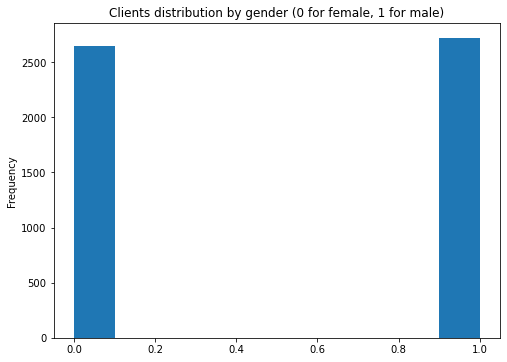

In [794]:
#plotting customers distribution by age
df_client2 ['gender'].plot (kind = 'hist',
                    title = 'Clients distribution by gender (0 for female, 1 for male)',
                   # width = 0.75,
                    figsize = (8, 5.8)
                    )

In [707]:
df_client2.iloc[2640:2650, :]

,client_id,birth_number,district_id,birth_date,gender,age
185,196,275625,74,270625,0.0,NaN
126,136,215126,55,210126,0.0,NaN
136,146,616219,31,611219,0.0,NaN
128,138,726021,54,721021,0.0,NaN
914,964,536021,10,531021,0.0,NaN
4058,4289,811123,66,811123,1.0,NaN
4392,4647,780820,8,780820,1.0,NaN
4386,4639,800516,20,800516,1.0,NaN
758,796,190830,1,190830,1.0,NaN
3881,4100,550313,74,550313,1.0,NaN


In [708]:
#converting birth_date into date format
df_client = date_correction (df_client, 'birth_date') 

In [709]:
df_client

,client_id,birth_number,district_id,birth_date,gender,age
0,1,706213,18,1970-12-13,0.0,NaN
1,2,450204,1,2045-02-04,1.0,NaN
2,3,406009,1,2040-10-09,0.0,NaN
3,4,561201,5,2056-12-01,1.0,NaN
4,5,605703,5,2060-07-03,0.0,NaN
...,...,...,...,...,...,...
5364,13955,456030,1,2045-10-30,0.0,NaN
5365,13956,430406,1,2043-04-06,1.0,NaN
5366,13968,680413,61,2068-04-13,1.0,NaN
5367,13971,626019,67,2062-10-19,0.0,NaN


In [710]:
#correcting misinterpreted dates
df_client ['birth_date'] = df_client ['birth_date'].apply (date_misinterp_cor)

In [711]:
df_client

,client_id,birth_number,district_id,birth_date,gender,age
0,1,706213,18,1970-12-13,0.0,NaN
1,2,450204,1,1945-02-04,1.0,NaN
2,3,406009,1,1940-10-09,0.0,NaN
3,4,561201,5,1956-12-01,1.0,NaN
4,5,605703,5,1960-07-03,0.0,NaN
...,...,...,...,...,...,...
5364,13955,456030,1,1945-10-30,0.0,NaN
5365,13956,430406,1,1943-04-06,1.0,NaN
5366,13968,680413,61,1968-04-13,1.0,NaN
5367,13971,626019,67,1962-10-19,0.0,NaN


In [712]:
#calculating age as of on 31.12.1998 
df_client ['age'] = df_client ['birth_date'].apply (calculate_age)
display (df_client.head (n=3))

,client_id,birth_number,district_id,birth_date,gender,age
0,1,706213,18,1970-12-13,0.0,28
1,2,450204,1,1945-02-04,1.0,53
2,3,406009,1,1940-10-09,0.0,58


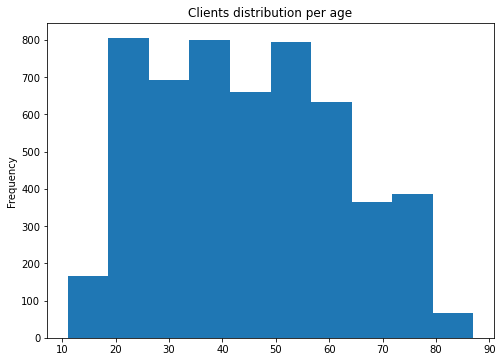

In [713]:
#plotting customers distribution by age
df_client ['age'].plot (kind = 'hist',
                    title = 'Clients distribution per age',
                   # width = 0.75,
                    figsize = (8, 5.8)
                    )

In [714]:
# Account / Frequency / df_account
# Translated values as follows:
# POPLATEK MESICNE changed to MONTHLY ISSUANCE (MI)
# POPLATEK TYDNE changed to WEEKLY ISSUANCE (WI)
# POPLATEK PO OBRATU change to ISSUANCE AFTER TRANSACTION (TI) 

# translate frequency to english.
def convert_freq_to_eng(x):
    if x == 'POPLATEK MESICNE':
        return 'MONTHLY'
    elif x == 'POPLATEK TYDNE':
        return 'WEEKLY'
    elif x == 'POPLATEK PO OBRATU':
        return 'TRANSACTION'
    else:
        return 'UNKNOWN'
    
df_account['frequency'] = df_account['frequency'].map(convert_freq_to_eng)

In [715]:
df_account = df_account.rename(columns={'frequency': 'statement_freq'})
df_account.head()

,account_id,district_id,statement_freq,date
0,576,55,MONTHLY,1993-01-01
1,3818,74,MONTHLY,1993-01-01
2,704,55,MONTHLY,1993-01-01
3,2378,16,MONTHLY,1993-01-01
4,2632,24,MONTHLY,1993-01-02


In [716]:
# rename disp_type / df_disp

df_disp = df_disp.rename(columns={'type': 'disp_type'})
df_disp.head()

,disp_id,client_id,account_id,disp_type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [717]:
df_disp['disp_type'].value_counts()

OWNER        4500
DISPONENT     869
Name: disp_type, dtype: int64

In [718]:
# df_district
# A1: District Identifier 
# A2: District Name 
# A3: Region Name 
# A4: Number of Inhabitants 
# A5: Number of municipalities with <499 inhabitants 
# A6: Number of municipalities with 500-1499 inhabitants 
# A7: Number of municipalities with 2000-9999 inhabitants 
# A8: Number of municipalities with >10000 inhabitants 
# A9: Number of cities 
# A10: Ratio of urban inhabitants 
# A11: Average salary 
# A12: 1995 unemployment rate 
# A13: 1996 unemployment rate 
# A14: Entrepreneurs per 1000 inhabitants 
# A15: Number of crimes committed in 1995 
# A16: Number of crimes committed in 1996

# rename A1 so it is clear that it is district_id.
df_district = df_district.rename(columns={'A1':'district_id', 'A2':'district_name', 'A3':'region', 'A4':'num_inhabitants', 'A5':'num_munipalities_gt499',
 'A6':'num_munipalities_500to1999', 'A7':'num_munipalities_2000to9999', 'A8':'num_munipalities_gt10000',
 'A9':'num_cities', 'A10':'ratio_urban', 'A11':'average_salary', 'A12':'unemp_rate95', 'A13': 'unemp_rate96',
 'A14':'num_entrep_per1000', 'A15':'num_crimes95', 'A16':'num_crimes96'})

df_district.head()

,district_id,district_name,region,num_inhabitants,num_munipalities_gt499,num_munipalities_500to1999,num_munipalities_2000to9999,num_munipalities_gt10000,num_cities,ratio_urban,average_salary,unemp_rate95,unemp_rate96,num_entrep_per1000,num_crimes95,num_crimes96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [719]:
print(df_district.dtypes)
df_district['unemp_rate95'].value_counts()[1:50]
#df_district['num_crimes95'].value_counts()[1:50]

district_id                      int64
district_name                   object
region                          object
num_inhabitants                  int64
num_munipalities_gt499           int64
num_munipalities_500to1999       int64
num_munipalities_2000to9999      int64
num_munipalities_gt10000         int64
num_cities                       int64
ratio_urban                    float64
average_salary                   int64
unemp_rate95                    object
unemp_rate96                   float64
num_entrep_per1000               int64
num_crimes95                    object
num_crimes96                     int64
dtype: object


3.33    2
3.38    2
3.13    2
1.60    2
1.79    2
5.75    1
5.93    1
1.39    1
2.64    1
2.95    1
4.64    1
1.29    1
4.73    1
1.42    1
4.83    1
2.41    1
6.43    1
?       1
4.76    1
1.12    1
1.25    1
5.74    1
0.56    1
2.38    1
3.24    1
4.75    1
5.38    1
3.85    1
1.67    1
0.29    1
4.01    1
5.77    1
2.83    1
6.49    1
7.34    1
2.53    1
1.78    1
1.02    1
2.26    1
7.08    1
3.80    1
2.47    1
1.10    1
0.65    1
3.51    1
3.73    1
0.45    1
6.63    1
2.28    1
Name: unemp_rate95, dtype: int64

In [720]:
df_district['num_crimes95'].value_counts()[1:50]

18721    1
4980     1
5796     1
4289     1
6041     1
3810     1
6949     1
3659     1
1879     1
1328     1
1655     1
3384     1
3804     1
2719     1
1658     1
1660     1
2879     1
4085     1
2212     1
2595     1
2112     1
2564     1
3475     1
2640     1
1562     1
2247     1
4147     1
18782    1
4484     1
4650     1
1874     1
3244     1
5198     1
5244     1
5623     1
1003     1
2824     1
3460     1
1850     1
5323     1
1740     1
6445     1
3736     1
818      1
5179     1
2653     1
2123     1
4355     1
1845     1
Name: num_crimes95, dtype: int64

In [721]:
def convert_question_marks(x, typ):
    if x == '?':
        return -1
    elif typ == 'float':
        return float(x)
    else:
        return int(x)
    
df_district['unemp_rate95'] = df_district['unemp_rate95'].apply(convert_question_marks, args=('float',))
df_district['num_crimes95'] = df_district['num_crimes95'].apply(convert_question_marks, args=('int',))

In [722]:
df_district.dtypes

district_id                      int64
district_name                   object
region                          object
num_inhabitants                  int64
num_munipalities_gt499           int64
num_munipalities_500to1999       int64
num_munipalities_2000to9999      int64
num_munipalities_gt10000         int64
num_cities                       int64
ratio_urban                    float64
average_salary                   int64
unemp_rate95                   float64
unemp_rate96                   float64
num_entrep_per1000               int64
num_crimes95                     int64
num_crimes96                     int64
dtype: object

In [723]:
df_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [724]:
df_trans.dtypes

trans_id               int64
account_id             int64
date          datetime64[ns]
type                  object
operation             object
amount               float64
balance              float64
k_symbol              object
bank                  object
account              float64
dtype: object

In [725]:
# transaction / df_trans
# type
# PRIJEM = Credit
# VYDAJ = Withdrawal 

# transaction / df_trans
# operation (Mode of transaction)
# VYBER KARTOU = Credit Card Withdrawal (CCW)
# VKLAD = Credit in Cash (CRC)
# PREVOD Z UCTU = Collection from Another Bank (CAB)
# VYBER = Withdrawal in Cash (WC)
# PREVOD NA UCET = Remittance to Another Bank (RAB) 

# transaction / df_trans
# k_symbol (Characterization of transaction)
# POJISTNE = Insurance Payment (IP)
# SLUZBY = Payment on Statement (PS)
# UROK = Interest Credited (ICR)
# SANKC. UROK - Sanction Interest (SI)
# SIPO - Household (H)
# DUCHOD - Old-age Pension (OP)
# UVER - Loan Payment (LP) 

In [726]:
def convert_trans_type_to_eng(x):
    if x == 'PRIJEM':
        return 'CREDIT'
    elif x == 'VYDAJ':
        return 'WITHDRAWAL'
    else:
        return 'UNKNOWN'
    
def convert_trans_op_to_eng(x):
    if x == 'VYBER KARTOU':
        return 'CC_WITHDRAWAL'
    elif x == 'VKLAD':
        return 'CREDIT_IN_CASH'
    elif x == 'PREVOD Z UCTU':
        return 'COLLECTION_FROM_OTHER_BANK'
    elif x == 'VYBER':
        return 'WITHDRAWAL_IN_CASH'
    elif x == 'PREVOD NA UCET':
        return 'REMITTANCE_TO_OTHER_BANK'    
    else:
        return 'UNKNOWN'
    
def convert_trans_k_symbol_to_eng(x):
    if x == 'POJISTNE':
        return 'INSURANCE_PAYMENT'
    elif x == 'SLUZBY':
        return 'PAYMENT_ON_STATEMENT'
    elif x == 'UROK':
        return 'INTEREST_CREDITED'
    elif x == 'SANKC. UROK':
        return 'SANCTION_INTEREST'
    elif x == 'SIPO':
        return 'HOUSEHOLD'
    elif x == 'DUCHOD':
        return 'OLD_AGE_PENSION'  
    elif x == 'UVER':
        return 'LOAN_PAYMENT'      
    else:
        return 'UNKNOWN'

In [727]:
df_trans['trans_type'] = df_trans['type'].map(convert_trans_type_to_eng)
df_trans['trans_operation'] = df_trans['operation'].map(convert_trans_op_to_eng)
df_trans['trans_k_symbol'] = df_trans['k_symbol'].map(convert_trans_k_symbol_to_eng)

In [728]:
df_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,trans_type,trans_operation,trans_k_symbol
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN


In [729]:
df_trans.drop(['type', 'operation', 'k_symbol'], axis = 1, inplace=True)

In [730]:
df_trans.head()

,trans_id,account_id,date,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol
0,695247,2378,1993-01-01,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1,171812,576,1993-01-01,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
2,207264,704,1993-01-01,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
3,1117247,3818,1993-01-01,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
4,579373,1972,1993-01-02,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN


In [731]:
df_trans.isnull().sum()

trans_id                0
account_id              0
date                    0
amount                  0
balance                 0
bank               782812
account            760931
trans_type              0
trans_operation         0
trans_k_symbol          0
dtype: int64

In [732]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   trans_id         1056320 non-null  int64         
 1   account_id       1056320 non-null  int64         
 2   date             1056320 non-null  datetime64[ns]
 3   amount           1056320 non-null  float64       
 4   balance          1056320 non-null  float64       
 5   bank             273508 non-null   object        
 6   account          295389 non-null   float64       
 7   trans_type       1056320 non-null  object        
 8   trans_operation  1056320 non-null  object        
 9   trans_k_symbol   1056320 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 80.6+ MB


In [733]:
df_loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [734]:
df_loan = df_loan.rename(columns={'amount': 'loan_amount', 'duration':'loan_duration', 'payments':'monthly_loan_payment', 'status':'loan_status'})
df_loan.head()

,loan_id,account_id,date,loan_amount,loan_duration,monthly_loan_payment,loan_status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [735]:
df_order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [736]:
df_order['k_symbol'].value_counts()

SIPO        3502
            1379
UVER         717
POJISTNE     532
LEASING      341
Name: k_symbol, dtype: int64

In [737]:
# translate k_symbol to english.
def convert_k_symbol_to_eng(x):
    if x == 'POJISTNE':
        return 'INSURANCE_PAYMENT'
    elif x == 'SIPO':
        return 'HOUSEHOLD_PAYMENT'
    elif x == 'LEASING':
        return 'LEASING_PAYMENT'
    elif x == 'UVER':
        return 'LOAN_PAYMENT'
    else:
        return 'UNKNOWN'

In [738]:
df_order['order_k_symbol'] = df_order['k_symbol'].map(convert_k_symbol_to_eng)

In [739]:
df_order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol,order_k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO,HOUSEHOLD_PAYMENT
1,29402,2,ST,89597016,3372.7,UVER,LOAN_PAYMENT
2,29403,2,QR,13943797,7266.0,SIPO,HOUSEHOLD_PAYMENT
3,29404,3,WX,83084338,1135.0,SIPO,HOUSEHOLD_PAYMENT
4,29405,3,CD,24485939,327.0,,UNKNOWN


In [740]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        6471 non-null   int64  
 1   account_id      6471 non-null   int64  
 2   bank_to         6471 non-null   object 
 3   account_to      6471 non-null   int64  
 4   amount          6471 non-null   float64
 5   k_symbol        6471 non-null   object 
 6   order_k_symbol  6471 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 354.0+ KB


In [741]:
# order_k_symbol has 1379/6471 = 22% of values missing - may need to be dropped

df_order['order_k_symbol'].value_counts()

HOUSEHOLD_PAYMENT    3502
UNKNOWN              1379
LOAN_PAYMENT          717
INSURANCE_PAYMENT     532
LEASING_PAYMENT       341
Name: order_k_symbol, dtype: int64

In [742]:
df_order = df_order.rename(columns={'bank_to': 'order_bank_to', 'account_to':'order_account_to', 'amount':'order_amount'})
df_order.head()

,order_id,account_id,order_bank_to,order_account_to,order_amount,k_symbol,order_k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO,HOUSEHOLD_PAYMENT
1,29402,2,ST,89597016,3372.7,UVER,LOAN_PAYMENT
2,29403,2,QR,13943797,7266.0,SIPO,HOUSEHOLD_PAYMENT
3,29404,3,WX,83084338,1135.0,SIPO,HOUSEHOLD_PAYMENT
4,29405,3,CD,24485939,327.0,,UNKNOWN


## End of Data Cleaning

In [743]:
df_order.to_csv("./datasets/df_order.csv", index=False)

In [744]:
df_loan.to_csv("./datasets/df_loan.csv", index=False)

In [745]:
df_trans.to_csv("./datasets/df_trans.csv", index=False)

In [746]:
df_district.to_csv("./datasets/df_district.csv", index=False)

In [747]:
df_disp.to_csv("./datasets/df_disp.csv", index=False)

In [748]:
df_account.to_csv("./datasets/df_account.csv", index=False)

In [749]:
df_client.to_csv("./datasets/df_client.csv", index=False)

In [750]:
df_card.to_csv("./datasets/df_card.csv", index=False)

## EDA

In [751]:
df_trans.head()

,trans_id,account_id,date,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol
0,695247,2378,1993-01-01,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1,171812,576,1993-01-01,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
2,207264,704,1993-01-01,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
3,1117247,3818,1993-01-01,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
4,579373,1972,1993-01-02,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN


In [752]:
# Set index to be the date column as a DatetimeIndex.
df_trans.set_index(pd.to_datetime(df_trans['date']), inplace=True)

# Drop the date column from our data.
df_trans.drop(columns='date', inplace=True)

# Confirm.
df_trans

,trans_id,account_id,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol
date,,,,,,,,,
1993-01-01,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1993-01-01,171812,576,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1993-01-01,207264,704,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1993-01-01,1117247,3818,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
1993-01-02,579373,1972,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN
...,...,...,...,...,...,...,...,...,...
1998-12-31,3626622,2906,62.3,13729.4,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED
1998-12-31,3627616,2935,81.3,19544.9,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED
1998-12-31,3625403,2869,60.2,14638.2,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED


In [753]:
df_trans.shape

(1056320, 9)

In [754]:
df_district.head()

,district_id,district_name,region,num_inhabitants,num_munipalities_gt499,num_munipalities_500to1999,num_munipalities_2000to9999,num_munipalities_gt10000,num_cities,ratio_urban,average_salary,unemp_rate95,unemp_rate96,num_entrep_per1000,num_crimes95,num_crimes96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [755]:
df_district2 = df_district.sort_values('average_salary', ascending=False)

In [756]:
df_district2.head(10)

,district_id,district_name,region,num_inhabitants,num_munipalities_gt499,num_munipalities_500to1999,num_munipalities_2000to9999,num_munipalities_gt10000,num_cities,ratio_urban,average_salary,unemp_rate95,unemp_rate96,num_entrep_per1000,num_crimes95,num_crimes96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
7,8,Mlada Boleslav,central Bohemia,112065,95,19,7,1,8,69.4,11277,1.25,1.44,127,5179,4987
25,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041,6261
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
38,39,Most,north Bohemia,119895,17,4,3,2,4,89.9,10446,7.34,9.40,90,4947,4743
69,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878,10108
9,10,Praha - vychod,central Bohemia,92084,55,29,4,3,5,46.7,10124,0.56,0.54,141,3810,4316
13,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604,6295
6,7,Melnik,central Bohemia,94725,38,28,1,3,6,63.4,9920,2.26,2.87,130,4289,4846
53,54,Brno - mesto,south Moravia,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696


In [773]:
df_loan.head()

,loan_id,account_id,date,loan_amount,loan_duration,monthly_loan_payment,loan_status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [775]:
#Preparing loans dataset on loans status and good/bad loans and replacing A, B, C, D with description text
df_loan2 = df_loan.copy ()
df_loan2 ['loan_status_desc'] = df_loan2 ['loan_status']

dict1 =  {'A':'Contract finished, no problems', 
      'B':'Contract finised, loan was not paid',
      'C':'Runing contract, OK so far',
      'D':'Runing contract, client in debt'
     }
df_loan2.loan_status_desc = df_loan2.loan_status_desc.replace (dict1)

df_loan2 ['loan_status_numeric'] = df_loan2 ['loan_status']

#encoding bad loans as 1 and good ones as -1 
dict2 =  {'A':-1, 
      'B':1,
      'C':-1,
      'D':1
     }
df_loan2.loan_status_numeric = df_loan2.loan_status_numeric.replace (dict2)
df_loan2.head()
#display (df_loan2.head (n=3))

,loan_id,account_id,date,loan_amount,loan_duration,monthly_loan_payment,loan_status,loan_status_desc,loan_status_numeric
0,5314,1787,1993-07-05,96396,12,8033.0,B,"Contract finised, loan was not paid",1
1,5316,1801,1993-07-11,165960,36,4610.0,A,"Contract finished, no problems",-1
2,6863,9188,1993-07-28,127080,60,2118.0,A,"Contract finished, no problems",-1
3,5325,1843,1993-08-03,105804,36,2939.0,A,"Contract finished, no problems",-1
4,7240,11013,1993-09-06,274740,60,4579.0,A,"Contract finished, no problems",-1


In [776]:
#correlation between loan status and monthly payments
df_loan3 = df_loan2.groupby (['loan_status_desc']).mean () ['monthly_loan_payment'].sort_values ()

In [777]:
df_loan3

loan_status_desc
Runing contract, OK so far             3938.535980
Contract finished, no problems         4264.137931
Runing contract, client in debt        5286.644444
Contract finised, loan was not paid    5396.258065
Name: monthly_loan_payment, dtype: float64

In [778]:
#correlation between loan status and duration of a loan 
df_loan4 = df_loan2.groupby (['loan_status_desc']).mean () ['loan_duration'].sort_values ()

In [779]:
df_loan4

loan_status_desc
Contract finished, no problems         22.226601
Contract finised, loan was not paid    25.548387
Runing contract, OK so far             43.444169
Runing contract, client in debt        46.133333
Name: loan_duration, dtype: float64

In [846]:
#correlation between loan status and loan's amount 
df_loan5 = df_loan2.groupby (['loan_status_desc']).mean () ['loan_amount'].sort_values ()

In [847]:
df_loan5

loan_status_desc
Contract finished, no problems          91641.458128
Contract finised, loan was not paid    140720.903226
Runing contract, OK so far             171410.352357
Runing contract, client in debt        249284.533333
Name: loan_amount, dtype: float64

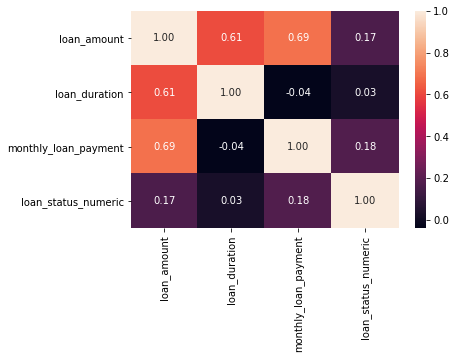

In [782]:
#correlation matrix
df_loan6 = df_loan2.copy ()
df_loan6.drop (['loan_id', 'account_id', 'date'], axis =1, inplace = True)
sns.heatmap (df_loan6.corr (), annot = True, fmt=".2f");

In [783]:
df_trans.head()

,trans_id,account_id,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol,amount_multiplier,trans_amount
date,,,,,,,,,,,
1993-01-01,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,700.0
1993-01-01,171812,576,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,900.0
1993-01-01,207264,704,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,1000.0
1993-01-01,1117247,3818,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,600.0
1993-01-02,579373,1972,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,400.0


In [796]:
def barchart(df, col_name):
    df[col_name].value_counts().plot(kind='bar', title = 'Transaction Types', figsize = (8, 5.8), subplots=False)

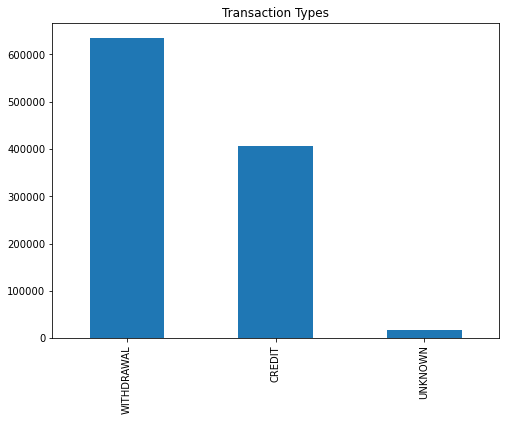

In [797]:
# here we see there are a small number of unknown transaction types.
barchart(df_trans, 'trans_type')

In [834]:
plt.rcParams['figure.figsize'] = [12, 10]

In [843]:
def boxplot(df, col_names, by=None):
    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
    df.boxplot(column=col_names, return_type='axes', by=by)
    plt.xticks(rotation=30)

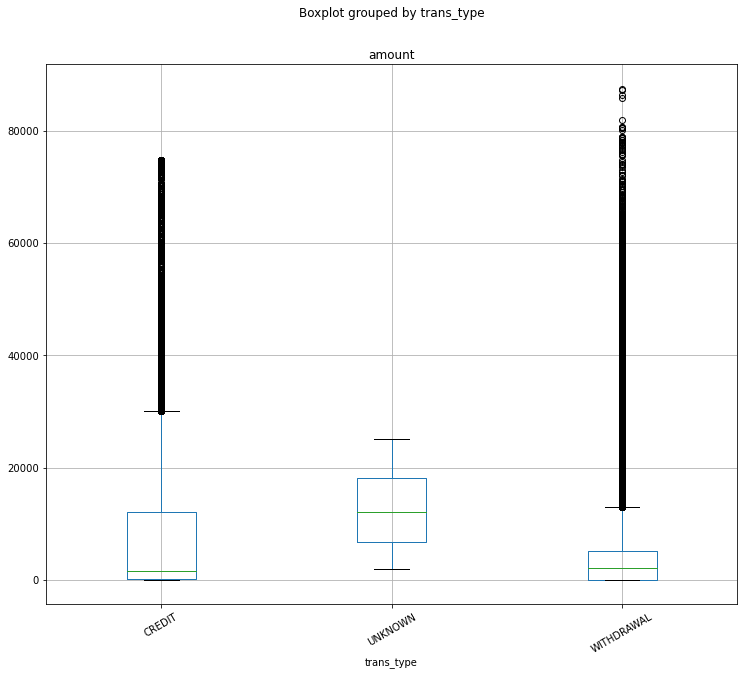

In [844]:
# examining the boxplots we can see that is more heavily skewed for withdrawals than credits.
boxplot(df_trans, ['amount'], by='trans_type')

In [837]:
plt.rcParams['figure.figsize'] = [12, 10]

In [838]:
def histogram_by_level(df, varName, targetName):
    lvls = df[varName].value_counts()
    for i in lvls.index:
        plt.hist(df[df[varName] == i][targetName], alpha=0.5, label=i, bins=300)
       
    plt.legend(loc='upper right')
    plt.show()

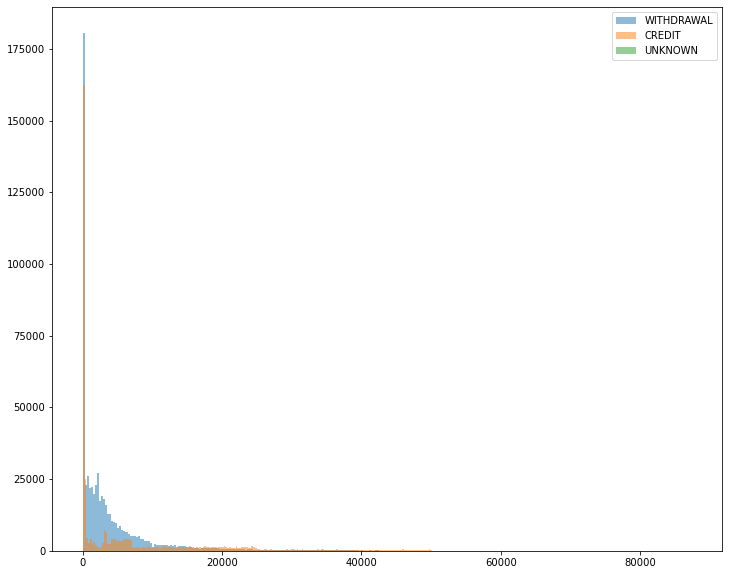

In [839]:
# histogram by transaction type shows the highly skewed nature of transaction amounts.
histogram_by_level(df_trans, 'trans_type', 'amount')

,Percentage_ratio
CREDIT_IN_CASH,14.838591
COLLECTION_FROM_OTHER_BANK,6.174833
WITHDRAWAL_IN_CASH,41.172940
UNKNOWN,17.335088
REMITTANCE_TO_OTHER_BANK,19.717794
CC_WITHDRAWAL,0.760754


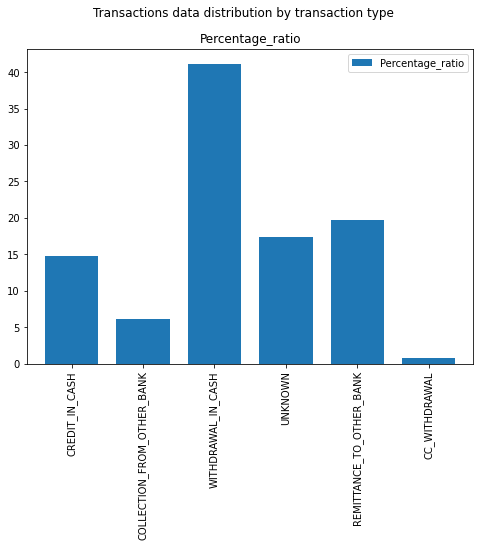

In [840]:
#Transactions Types popularity for the whole reported period 

df_trans_count = Counter (df_trans ['trans_operation'])

df_trans_count = pd.DataFrame.from_dict (df_trans_count, orient = 'index')
df_trans_count.columns = ['Percentage_ratio']
df_trans_count = df_trans_count / (df_trans_count ['Percentage_ratio'].sum ()) * 100

df_trans_count.plot (kind = 'bar',
                    title = 'Transactions data distribution by transaction type',
                    width = 0.75,
                    figsize = (8, 5.8),
                    subplots = True, 
                    )
df_trans_count 

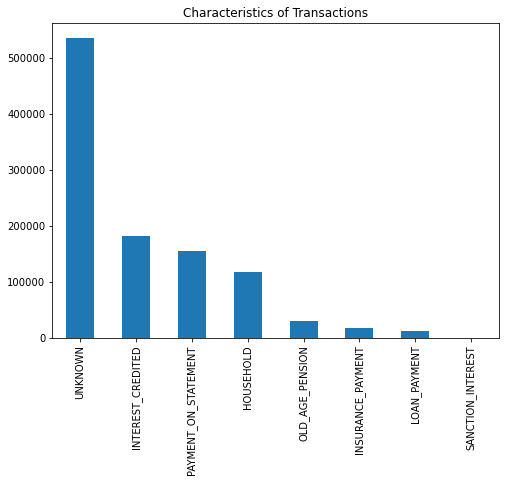

In [841]:
# trans_k_symbol looks to a classification of the purpose of the transaction. Unknown makes up over half of the transacions.
#barchart(df_trans, 'trans_k_symbol')
df_trans['trans_k_symbol'].value_counts().plot(kind='bar', title = 'Characteristics of Transactions', figsize = (8, 5.8), subplots=False)

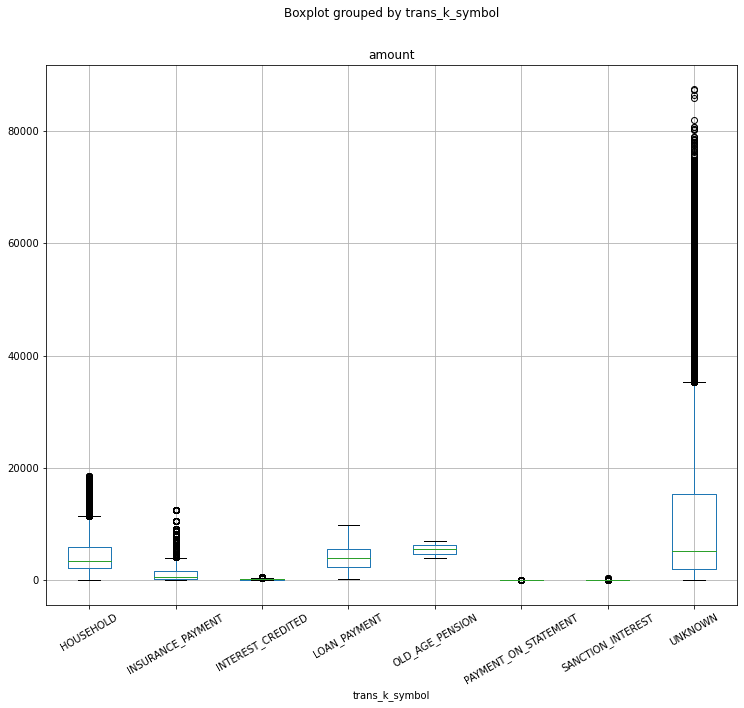

In [845]:
# This boxplot shows that unknown transactions are more highly skewed, which is not surprising.
# One possibility is that we only focus on the transactions we have no information about.
# Household and insurance payment are also skewed as well, but not to the same extent as unknown.
# all the other trans_k_symbols have lower variance and see to be the types which can be ignored.
boxplot(df_trans, ['amount'], by='trans_k_symbol')

## Start of Time Series Modelling

In [757]:
def convert_trans_amount_to_pos_neg(x):
    if x == 'CREDIT':
        return 1
    elif x == 'WITHDRAWAL':
        return -1
    else:
        return 0

In [758]:
df_trans['amount_multiplier'] = df_trans['trans_type'].map(convert_trans_amount_to_pos_neg)

In [759]:
df_trans[df_trans['trans_type'] == 'CREDIT']
#df_trans[df_trans['trans_type'] == 'WITHDRAWAL']
#df_trans[df_trans['trans_type'] == 'UNKNOWN']

,trans_id,account_id,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol,amount_multiplier
date,,,,,,,,,,
1993-01-01,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1
1993-01-01,171812,576,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1
1993-01-01,207264,704,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1
1993-01-01,1117247,3818,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1
1993-01-02,579373,1972,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1
...,...,...,...,...,...,...,...,...,...,...
1998-12-31,3626622,2906,62.3,13729.4,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1
1998-12-31,3627616,2935,81.3,19544.9,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1
1998-12-31,3625403,2869,60.2,14638.2,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1


In [760]:
df_trans['trans_amount'] = df_trans.amount * df_trans.amount_multiplier

In [761]:
df_trans[df_trans['trans_type'] == 'CREDIT']
#df_trans[df_trans['trans_type'] == 'WITHDRAWAL']
#df_trans[df_trans['trans_type'] == 'UNKNOWN']

,trans_id,account_id,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol,amount_multiplier,trans_amount
date,,,,,,,,,,,
1993-01-01,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,700.0
1993-01-01,171812,576,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,900.0
1993-01-01,207264,704,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,1000.0
1993-01-01,1117247,3818,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,600.0
1993-01-02,579373,1972,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1,400.0
...,...,...,...,...,...,...,...,...,...,...,...
1998-12-31,3626622,2906,62.3,13729.4,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,62.3
1998-12-31,3627616,2935,81.3,19544.9,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,81.3
1998-12-31,3625403,2869,60.2,14638.2,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,60.2


In [762]:
df_trans2 = df_trans[['trans_amount']]

In [763]:
df_trans2.head()

,trans_amount
date,
1993-01-01,700.0
1993-01-01,900.0
1993-01-01,1000.0
1993-01-01,600.0
1993-01-02,400.0


In [764]:
# Code modified from code written by Matthew Garton.

def plot_series(df_trans2, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df_trans2[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df_trans2.index[0::steps], fontsize=18);

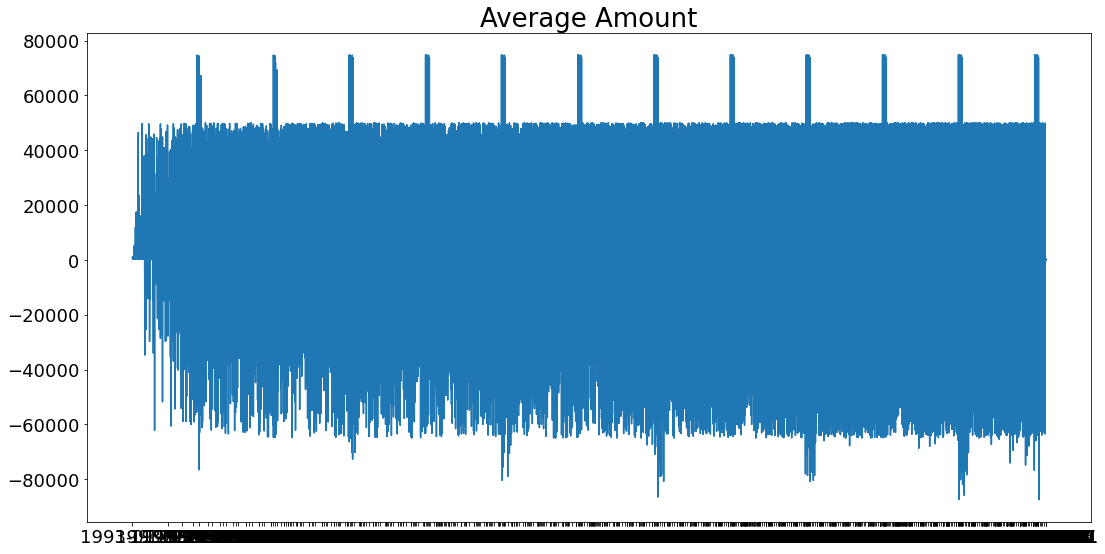

In [765]:
# Generate a time plot of our data.
plot_series(df_trans2, ['trans_amount'], title = "Average Amount", steps=1000)

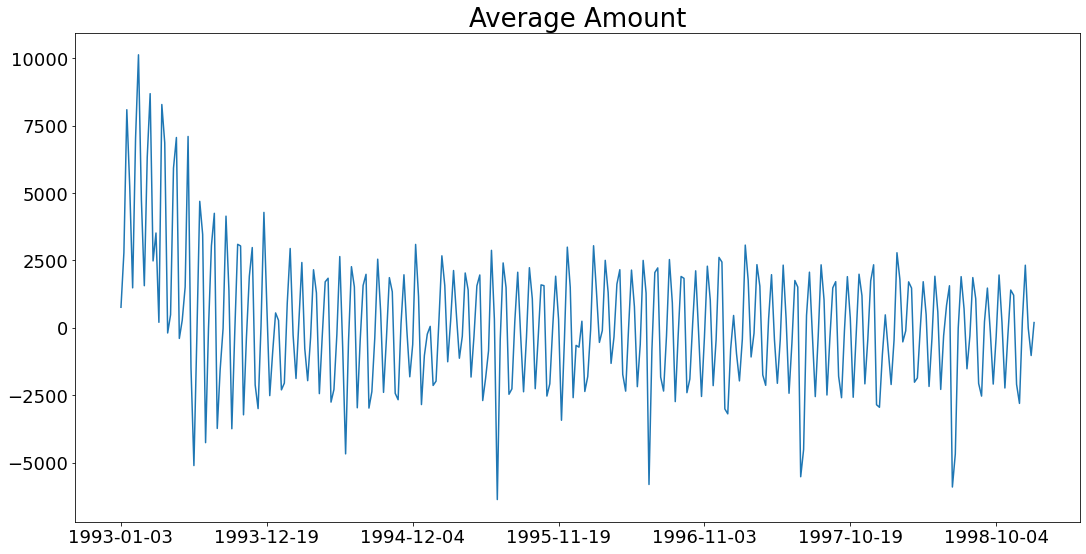

In [766]:
# Generate a time plot of our data.
plot_series(df_trans2.resample('W').mean(), cols=['trans_amount'], title='Average Amount', steps=50)

In [767]:
# Overwrite df.
df_trans2 = df_trans2.resample('W').mean()
df_trans2.head()

,trans_amount
date,
1993-01-03,763.636364
1993-01-10,2790.756757
1993-01-17,8088.941176
1993-01-24,5239.107143
1993-01-31,1483.292537


In [768]:
df_trans2.shape

(314, 1)

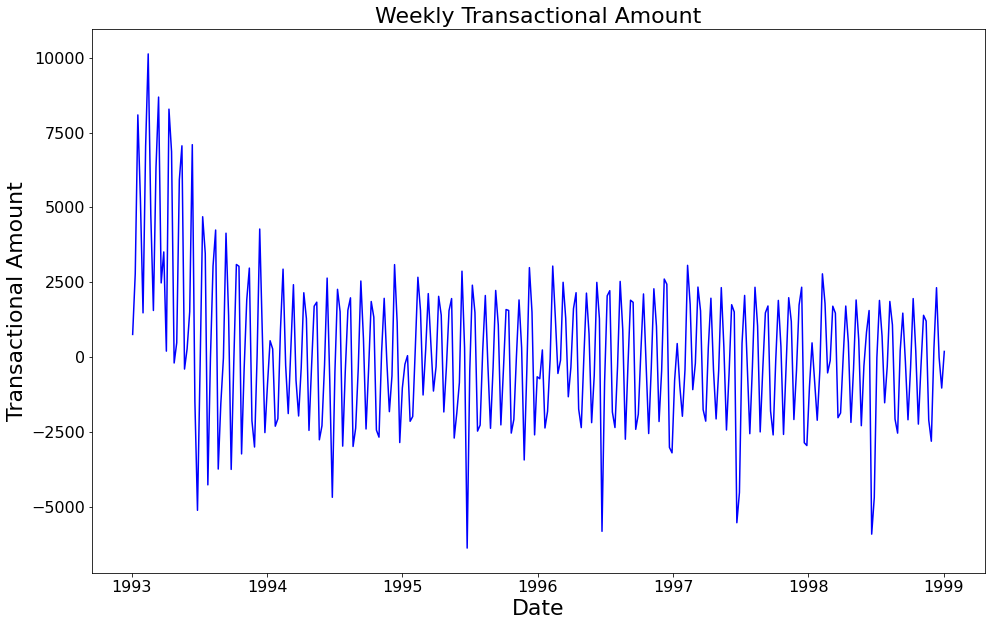

In [769]:
# Set figure size.
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(df_trans2, c ='blue')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Transactional Amount', fontsize=22)
plt.title('Weekly Transactional Amount', fontsize=22);

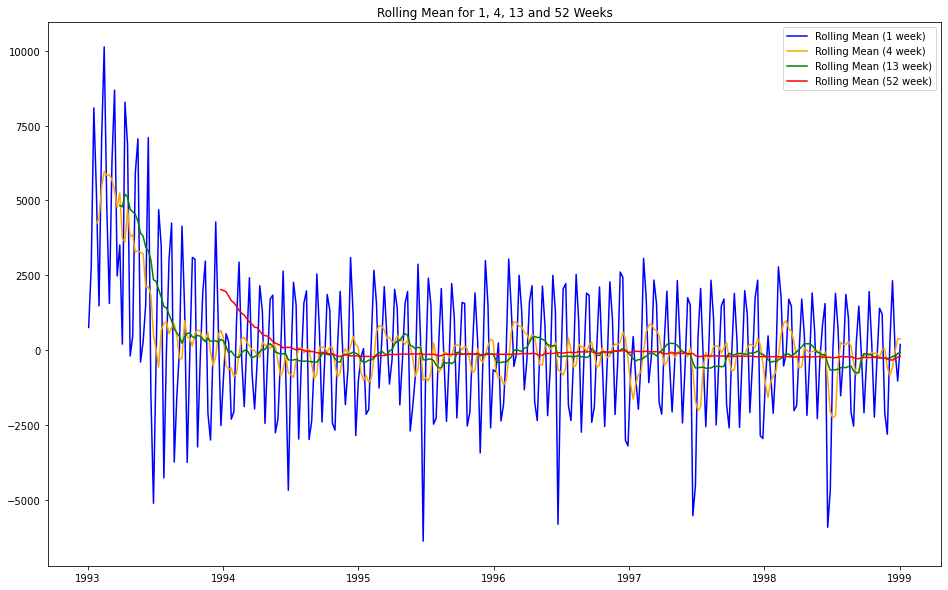

In [770]:
# Set a rolling mean with windows of 1, 4, 13 and 52.
rolmean1  = df_trans2.rolling(window = 1).mean()
rolmean4  = df_trans2.rolling(window = 4).mean()
rolmean13 = df_trans2.rolling(window = 13).mean()
rolmean52 = df_trans2.rolling(window = 52).mean()

# Plot
plt.figure(figsize=(16,10))
plt.plot(rolmean1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolmean13, color='green', label='Rolling Mean (13 week)')
plt.plot(rolmean52, color='red', label='Rolling Mean (52 week)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4, 13 and 52 Weeks')
plt.show()

In [771]:
print(f'Autocorrelation between Weekly Transactional Amount and 1-lag Weekly Transactional Amount: {round(df_trans2["trans_amount"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Transactional Amount and 2-lag Weekly Transactional Amount: {round(df_trans2["trans_amount"].autocorr(lag=2),4)}')
print(f'Autocorrelation between Weekly Transactional Amount and 4-lag Weekly Transactional Amount: {round(df_trans2["trans_amount"].autocorr(lag=4),4)}')
print(f'Autocorrelation between Weekly Transactional Amount and 13-lag Weekly Transactional Amount: {round(df_trans2["trans_amount"].autocorr(lag=13),4)}')
print(f'Autocorrelation between Weekly Transactional Amount and 52-lag Weekly Transactional Amount: {round(df_trans2["trans_amount"].autocorr(lag=52),4)}')

Autocorrelation between Weekly Transactional Amount and 1-lag Weekly Transactional Amount: 0.3093
Autocorrelation between Weekly Transactional Amount and 2-lag Weekly Transactional Amount: -0.3444
Autocorrelation between Weekly Transactional Amount and 4-lag Weekly Transactional Amount: 0.7415
Autocorrelation between Weekly Transactional Amount and 13-lag Weekly Transactional Amount: 0.7811
Autocorrelation between Weekly Transactional Amount and 52-lag Weekly Transactional Amount: 0.7717


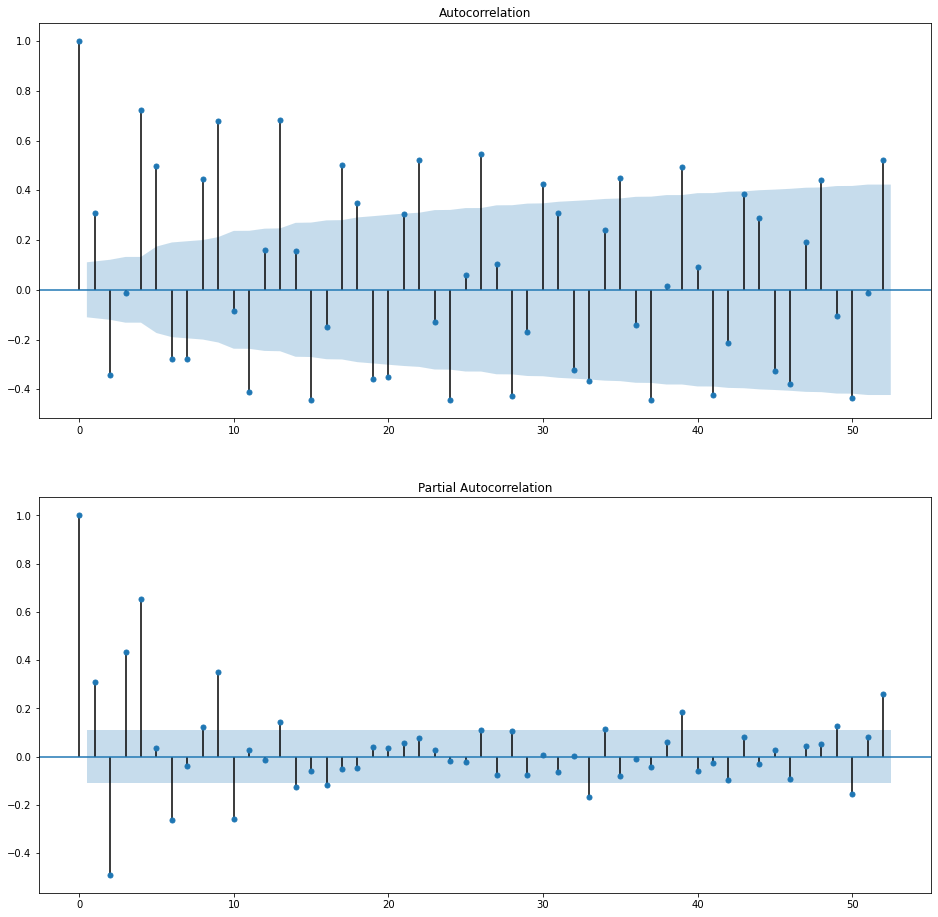

In [772]:
# 52-week  Autocorr and Partial Autocorr
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_trans2, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_trans2, lags=52, ax=ax2);

# If you do not use plt.show() it will plot the same vizualization twice.
# This may be a bug you can fix and submit to contribute to open source!

### The Data Science Process

**4. Preprocessing and Modeling**

**Time Series Modelling for All Transactions Data**

In [480]:
df_trans2.head()

,trans_amount
date,
1993-01-03,763.636364
1993-01-10,2790.756757
1993-01-17,8088.941176
1993-01-24,5239.107143
1993-01-31,1483.292537


In [481]:
df_trans2.shape

(314, 1)

In [268]:
# What index gives us our 80th percentile of rows?
df_trans2.shape[0] * (4 / 5)

251.20000000000002

In [269]:
# Set training data to be first 80% of rows.
train = df_trans2.iloc[0:251]

In [270]:
# Set test data to be last 20% of rows.
test = df_trans2.iloc[251:]

In [271]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 149.
ar1 = ARIMA(endog = train['trans_amount'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=251, end=313)

# Evaluate predictions.
mean_squared_error(test['trans_amount'], preds)

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


3575476.9259849642

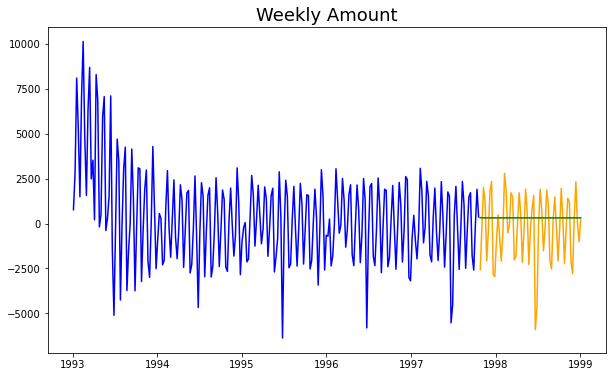

In [272]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['trans_amount'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['trans_amount'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Weekly Amount', fontsize=18)
plt.show();

In [273]:
# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(train['trans_amount']))

Test Statistic   -5.776056e+00
p-value           5.256346e-07
dtype: float64

In [274]:
# Because 𝑝≈5.256346e-07<0.05=𝛼, 
# we reject 𝐻0 that our data are not stationary 
# and accept 𝐻𝐴 that our data are stationary. 
# This means we can fit an ARIMA model to this data without differencing.

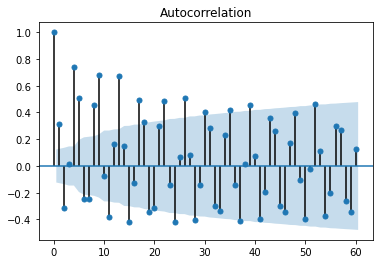

In [275]:
# Generate autocorrelation plot on training data.
plot_acf(train['trans_amount'], lags = 60);

# Note: we would generate the ACF plot on 
# differenced data, if we needed to difference
# in order to achieve stationarity!

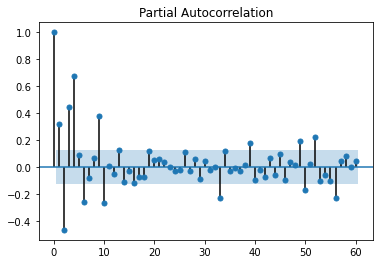

In [276]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['trans_amount'], lags = 60);

# Note: we would generate the PACF plot on 
# differenced data, if we needed to difference
# in order to achieve stationarity!

**Does my PACF have a sharp cut-off?**
> It appears so. I observe a sharp cut-off between lags 0 and 1 as well as a sharp cut-off between lags 1 and 2 in this image. I'll fit two models and compare them (one assuming the cut-off is between 0 and 1, and one assuming the cut-off is between 1 and 2).

**Is the first-lag value in the autocorrelation plot positive or negative?**
> It is positive. (Note that the first-lag value should always be the same in the ACF and PACF plots.)

**What model should we fit?**
> "If your PACF has a sharp cut-off and the first lag of your ACF (autocorrelation function) value is positive, choose an $AR(p)$ term where $p$ is the lag in the PACF after the cut-off." Thus, I will fit an $AR(1)$ model and an $AR(2)$ model and see how well they perform.

In [277]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 149.
ar1 = ARIMA(endog = train['trans_amount'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=251, end=313)

# Evaluate predictions.
mean_squared_error(test['trans_amount'], preds)

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


3575476.9259849642

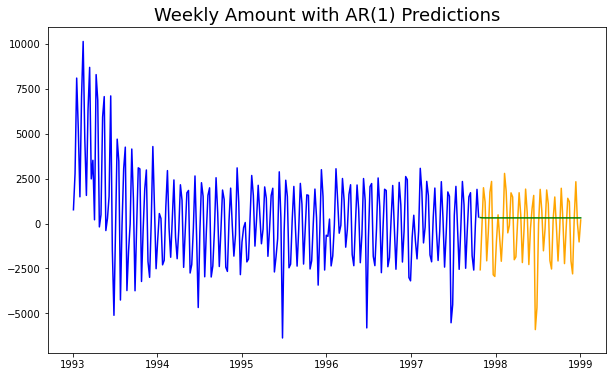

In [278]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['trans_amount'], color = 'blue')
plt.plot(test['trans_amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly Amount with AR(1) Predictions', fontsize=18)
plt.show();

In [279]:
# Instantiate an AR(2) model on training data.
# Note this training data consists of the 
# time periods 0 through 149.
ar2 = ARIMA(endog = train['trans_amount'],
            order = (2, 0, 0)) # (p, d, q)

# Fit AR(2) model.
model = ar2.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=251, end=313)

# Evaluate predictions.
mean_squared_error(test['trans_amount'], preds)

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


3496290.1230802406

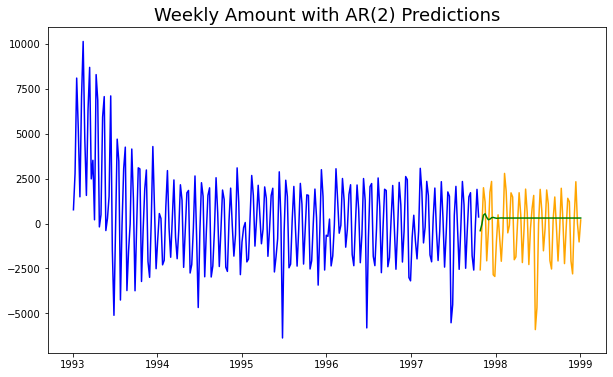

In [280]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['trans_amount'], color = 'blue')
plt.plot(test['trans_amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly Amount with AR(2) Predictions', fontsize=18)
plt.show();

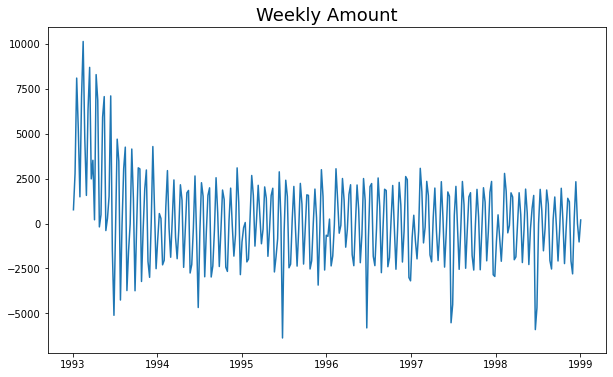

In [281]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(df_trans2['trans_amount'])
plt.title(label = 'Weekly Amount', fontsize=18)
plt.show();

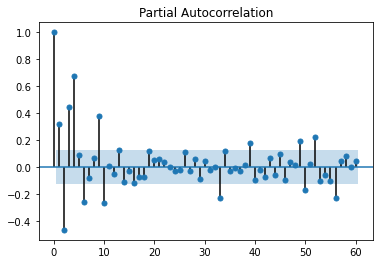

In [282]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['trans_amount'], lags = 60);

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


489666.54485474183


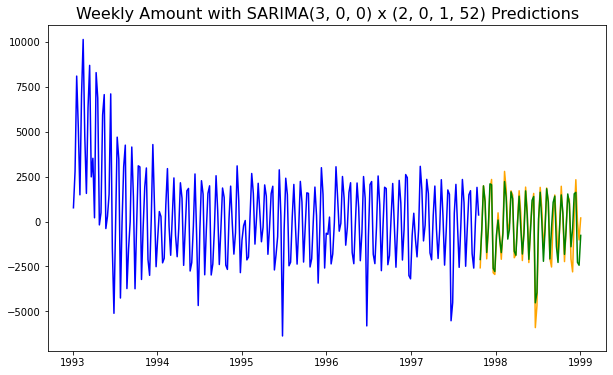

In [283]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 16) model.

sarima = SARIMAX(endog = train['trans_amount'],
                 order = (3, 0, 0),              # (p, d, q)
                 seasonal_order = (2, 0, 1, 52)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=251, end=313)

# Evaluate predictions.
print(mean_squared_error(test['trans_amount'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['trans_amount'], color = 'blue')
plt.plot(test['trans_amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly Amount with SARIMA(3, 0, 0) x (2, 0, 1, 52) Predictions', fontsize=16)
plt.show();

In [284]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = train['trans_amount'],
                                 order = (3, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 52)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 149.
                preds = model.predict(start=251, end=313)

                # Evaluate predictions.
                print(f'The MSE for (3, 0, 0)x({P},{D},{Q},52) is: {mean_squared_error(test["trans_amount"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(test["trans_amount"], preds):
                    mse = mean_squared_error(test["trans_amount"], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(3, 0, 0)x({final_P},{final_D},{final_Q},52).')
print(f'This model has an MSE of {mse}.')

The MSE for (3, 0, 0)x(0,0,0,52) is: 3144118.1971042906
The MSE for (3, 0, 0)x(0,1,0,52) is: 689966.1116857834
The MSE for (3, 0, 0)x(0,2,0,52) is: 2355116.4244875894
The MSE for (3, 0, 0)x(0,0,1,52) is: 1382055.7156153233


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (3, 0, 0)x(0,1,1,52) is: 848299.9156464282


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(0,2,1,52) is: 1064324.5581305632


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (3, 0, 0)x(0,0,2,52) is: 990482.4496974427


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (3, 0, 0)x(0,1,2,52) is: 836997.332464596


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (3, 0, 0)x(0,2,2,52) is: 1065431.2048210143
The MSE for (3, 0, 0)x(1,0,0,52) is: 513388.44655586156
The MSE for (3, 0, 0)x(1,1,0,52) is: 806263.0500936594
The MSE for (3, 0, 0)x(1,2,0,52) is: 1374468.1638162297
The MSE for (3, 0, 0)x(1,0,1,52) is: 502740.245256824


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (3, 0, 0)x(1,1,1,52) is: 825812.772766444


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(1,2,1,52) is: 1062998.4780369622


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (3, 0, 0)x(1,0,2,52) is: 528528.424055735


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (3, 0, 0)x(1,1,2,52) is: 831896.4797763327


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(1,2,2,52) is: 1065265.0709209864
The MSE for (3, 0, 0)x(2,0,0,52) is: 499471.4300001411
The MSE for (3, 0, 0)x(2,1,0,52) is: 813873.9482108842
The MSE for (3, 0, 0)x(2,2,0,52) is: 1161805.401115214


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(2,0,1,52) is: 489666.54485474183


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (3, 0, 0)x(2,1,1,52) is: 854012.4034845744


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(2,2,1,52) is: 1069497.537905181


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(2,0,2,52) is: 502743.34544391633


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (3, 0, 0)x(2,1,2,52) is: 863151.4567952888


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (3, 0, 0)x(2,2,2,52) is: 1082977.8703397484
Our model that minimizes MSE on the training data is the SARIMA(3, 0, 0)x(2,0,1,52).
This model has an MSE of 489666.54485474183.


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


489666.54485474183


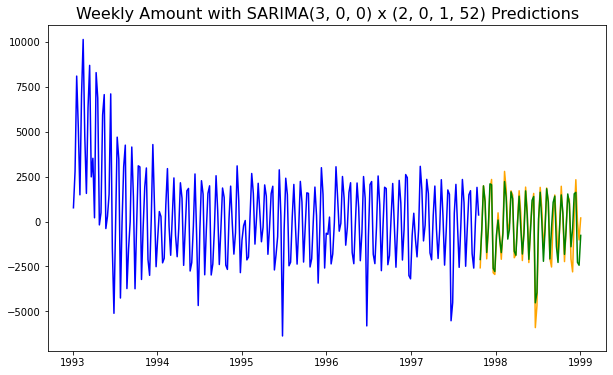

In [494]:
# Fit and visualize a SARIMA(1, 0, 0) x (2, 0, 0, 16) model.

sarima = SARIMAX(endog = train['trans_amount'],
                 order = (3, 0, 0),              # (p, d, q)
                 seasonal_order = (2, 0, 1, 52)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=251, end=313)

# Evaluate predictions.
print(mean_squared_error(test['trans_amount'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['trans_amount'], color = 'blue')
plt.plot(test['trans_amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Weekly Amount with SARIMA(3, 0, 0) x (2, 0, 1, 52) Predictions', fontsize=16)
plt.show();

**Client Segmentation Clustering**

## Start of Clustering

In [286]:
# df_trans['1993']
# df_trans['1994']
# df_trans['1995']
# df_trans['1996']
# df_trans['1997']
df_trans['1998']

,trans_id,account_id,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol,amount_multiplier,trans_amount
date,,,,,,,,,,,
1998-01-01,733597,2507,1300.0,30951.4,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-1300.0
1998-01-01,799525,2726,2760.0,79264.4,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-2760.0
1998-01-01,799963,2728,3200.0,62735.6,NaN,0.0,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-3200.0
1998-01-01,801636,2733,390.0,35140.8,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-390.0
1998-01-01,799151,2724,8700.0,41905.2,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-8700.0
...,...,...,...,...,...,...,...,...,...,...,...
1998-12-31,3626622,2906,62.3,13729.4,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,62.3
1998-12-31,3627616,2935,81.3,19544.9,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,81.3
1998-12-31,3625403,2869,60.2,14638.2,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,60.2


In [287]:
df_trans_1998 = df_trans['1998']

In [288]:
df_trans_1998

,trans_id,account_id,amount,balance,bank,account,trans_type,trans_operation,trans_k_symbol,amount_multiplier,trans_amount
date,,,,,,,,,,,
1998-01-01,733597,2507,1300.0,30951.4,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-1300.0
1998-01-01,799525,2726,2760.0,79264.4,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-2760.0
1998-01-01,799963,2728,3200.0,62735.6,NaN,0.0,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-3200.0
1998-01-01,801636,2733,390.0,35140.8,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-390.0
1998-01-01,799151,2724,8700.0,41905.2,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,-1,-8700.0
...,...,...,...,...,...,...,...,...,...,...,...
1998-12-31,3626622,2906,62.3,13729.4,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,62.3
1998-12-31,3627616,2935,81.3,19544.9,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,81.3
1998-12-31,3625403,2869,60.2,14638.2,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1,60.2


In [289]:
df_trans_1998_clus = df_trans_1998[['amount', 'balance', 'trans_type', 'trans_operation', 'trans_k_symbol']]

In [290]:
df_trans_1998_clus.head()

,amount,balance,trans_type,trans_operation,trans_k_symbol
date,,,,,
1998-01-01,1300.0,30951.4,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN
1998-01-01,2760.0,79264.4,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN
1998-01-01,3200.0,62735.6,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN
1998-01-01,390.0,35140.8,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN
1998-01-01,8700.0,41905.2,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN


In [291]:
df_trans_1998_clus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322277 entries, 1998-01-01 to 1998-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   amount           322277 non-null  float64
 1   balance          322277 non-null  float64
 2   trans_type       322277 non-null  object 
 3   trans_operation  322277 non-null  object 
 4   trans_k_symbol   322277 non-null  object 
dtypes: float64(2), object(3)
memory usage: 14.8+ MB


In [292]:
cat_var = ['trans_type', 'trans_operation', 'trans_k_symbol']

In [293]:
df_trans_1998_clus_dummies = pd.get_dummies(df_trans_1998_clus, columns = cat_var, drop_first = True)

In [294]:
df_trans_1998_clus_dummies.head()

,amount,balance,trans_type_UNKNOWN,trans_type_WITHDRAWAL,trans_operation_COLLECTION_FROM_OTHER_BANK,trans_operation_CREDIT_IN_CASH,trans_operation_REMITTANCE_TO_OTHER_BANK,trans_operation_UNKNOWN,trans_operation_WITHDRAWAL_IN_CASH,trans_k_symbol_INSURANCE_PAYMENT,trans_k_symbol_INTEREST_CREDITED,trans_k_symbol_LOAN_PAYMENT,trans_k_symbol_OLD_AGE_PENSION,trans_k_symbol_PAYMENT_ON_STATEMENT,trans_k_symbol_SANCTION_INTEREST,trans_k_symbol_UNKNOWN
date,,,,,,,,,,,,,,,,
1998-01-01,1300.0,30951.4,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1998-01-01,2760.0,79264.4,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1998-01-01,3200.0,62735.6,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1998-01-01,390.0,35140.8,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1998-01-01,8700.0,41905.2,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [295]:
df_trans_1998_clus_dummies.shape

(322277, 16)

In [296]:
ss = StandardScaler()
X_sc = ss.fit_transform(df_trans_1998_clus_dummies)

In [297]:
km = KMeans(n_clusters=10, random_state=42)
km.fit(X_sc)

KMeans(n_clusters=10, random_state=42)

In [298]:
# Check out centroids
km.cluster_centers_

array([[-0.26079168, -0.18926652, -0.13072666,  0.79220429, -0.25219618,
        -0.40260577,  1.91999227, -0.45178273, -0.82276148, -0.13776929,
        -0.45178273, -0.12613323, -0.16832905, -0.41525474, -0.04748357,
        -0.31263111],
       [-0.60247538, -0.10950137, -0.13072666, -1.26230066, -0.25219618,
        -0.40260577, -0.52083543,  2.21345336, -0.82276148, -0.13776929,
         2.21345336, -0.12613323, -0.16832905, -0.41525474, -0.04748357,
        -0.99827316],
       [ 0.21257154, -0.03408174, -0.13072666,  0.79205232, -0.25188422,
        -0.40260577, -0.52083543, -0.45178273,  1.10068757, -0.13776929,
        -0.45178273, -0.12613323, -0.16832905, -0.41525474, -0.04748357,
         0.98207844],
       [-0.61740669, -0.14347505, -0.13072666,  0.79220429, -0.25219618,
        -0.40260577, -0.52083543, -0.45178273,  1.21541909, -0.13776929,
        -0.45178273, -0.12613323, -0.16832905,  2.40816035, -0.04748357,
        -0.99827316],
       [ 1.09982776,  0.5424053 , -0

In [299]:
# Option 1: Class attribute
km.labels_

array([2, 2, 2, ..., 1, 1, 1])

In [300]:
# Option 2: Predict
km.predict(X_sc)

array([2, 2, 2, ..., 1, 1, 1])

In [301]:
# attach predicted cluster to original points
df_trans_1998_clus_dummies['cluster'] = km.labels_
df_trans_1998_clus_dummies.head()

,amount,balance,trans_type_UNKNOWN,trans_type_WITHDRAWAL,trans_operation_COLLECTION_FROM_OTHER_BANK,trans_operation_CREDIT_IN_CASH,trans_operation_REMITTANCE_TO_OTHER_BANK,trans_operation_UNKNOWN,trans_operation_WITHDRAWAL_IN_CASH,trans_k_symbol_INSURANCE_PAYMENT,trans_k_symbol_INTEREST_CREDITED,trans_k_symbol_LOAN_PAYMENT,trans_k_symbol_OLD_AGE_PENSION,trans_k_symbol_PAYMENT_ON_STATEMENT,trans_k_symbol_SANCTION_INTEREST,trans_k_symbol_UNKNOWN,cluster
date,,,,,,,,,,,,,,,,,
1998-01-01,1300.0,30951.4,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,2760.0,79264.4,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,3200.0,62735.6,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,390.0,35140.8,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,8700.0,41905.2,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2


In [302]:
km.cluster_centers_

array([[-0.26079168, -0.18926652, -0.13072666,  0.79220429, -0.25219618,
        -0.40260577,  1.91999227, -0.45178273, -0.82276148, -0.13776929,
        -0.45178273, -0.12613323, -0.16832905, -0.41525474, -0.04748357,
        -0.31263111],
       [-0.60247538, -0.10950137, -0.13072666, -1.26230066, -0.25219618,
        -0.40260577, -0.52083543,  2.21345336, -0.82276148, -0.13776929,
         2.21345336, -0.12613323, -0.16832905, -0.41525474, -0.04748357,
        -0.99827316],
       [ 0.21257154, -0.03408174, -0.13072666,  0.79205232, -0.25188422,
        -0.40260577, -0.52083543, -0.45178273,  1.10068757, -0.13776929,
        -0.45178273, -0.12613323, -0.16832905, -0.41525474, -0.04748357,
         0.98207844],
       [-0.61740669, -0.14347505, -0.13072666,  0.79220429, -0.25219618,
        -0.40260577, -0.52083543, -0.45178273,  1.21541909, -0.13776929,
        -0.45178273, -0.12613323, -0.16832905,  2.40816035, -0.04748357,
        -0.99827316],
       [ 1.09982776,  0.5424053 , -0

In [303]:
df_trans_1998_clus_dummies.groupby('cluster').mean()

,amount,balance,trans_type_UNKNOWN,trans_type_WITHDRAWAL,trans_operation_COLLECTION_FROM_OTHER_BANK,trans_operation_CREDIT_IN_CASH,trans_operation_REMITTANCE_TO_OTHER_BANK,trans_operation_UNKNOWN,trans_operation_WITHDRAWAL_IN_CASH,trans_k_symbol_INSURANCE_PAYMENT,trans_k_symbol_INTEREST_CREDITED,trans_k_symbol_LOAN_PAYMENT,trans_k_symbol_OLD_AGE_PENSION,trans_k_symbol_PAYMENT_ON_STATEMENT,trans_k_symbol_SANCTION_INTEREST,trans_k_symbol_UNKNOWN
cluster,,,,,,,,,,,,,,,,
0,3403.197637,36275.536246,0.0,1.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.342821
1,158.978898,38198.812323,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2,7898.024116,40022.311735,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.943779,0.0,0.0,0.0,0.0,0.0,0.0,0.990174
3,17.209106,37379.647997,0.0,1.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
4,16320.600968,53908.575873,0.0,0.0,0.187771,0.812229,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
5,5521.631081,28240.829775,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6,12482.134441,47462.694035,1.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
7,1306.453107,39919.790921,0.0,1.0,0.000000,0.000000,0.998667,0.0,0.001333,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,4060.536695,45595.911433,0.0,1.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.000000


In [304]:
silhouette_score(X_sc, km.labels_)

0.6227046345012585

In [107]:
scores = []
for k in range(7, 12): # min k is 2
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [108]:
score_df

,k,inertia,silhouette
0,7,1.715786e+06,0.563696
1,8,1.415145e+06,0.554403
2,9,1.126737e+06,0.597292
3,10,7.963064e+05,0.622705
4,11,5.741573e+05,0.658520


Text(0.5, 1.0, 'Silhouette Score over k')

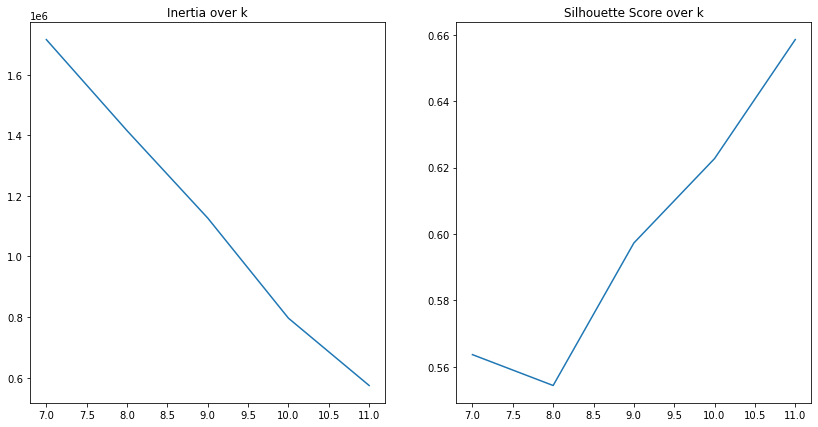

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

In [305]:
output = df_trans_1998_clus_dummies.groupby('cluster').mean()

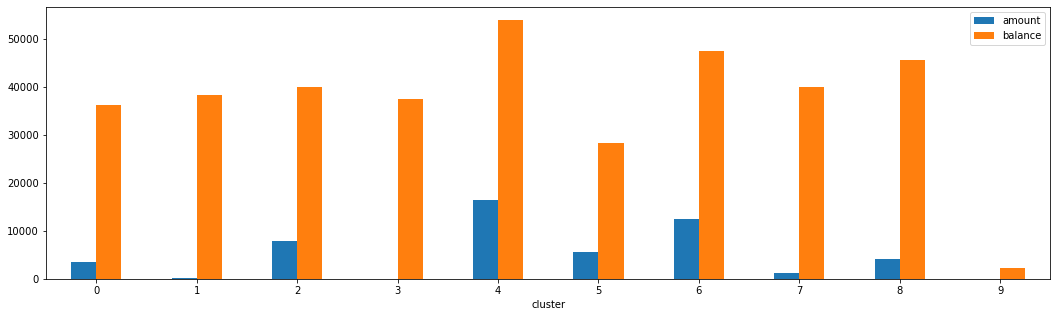

In [306]:
output[['amount','balance']].plot.bar(rot=0, figsize=(18,5));

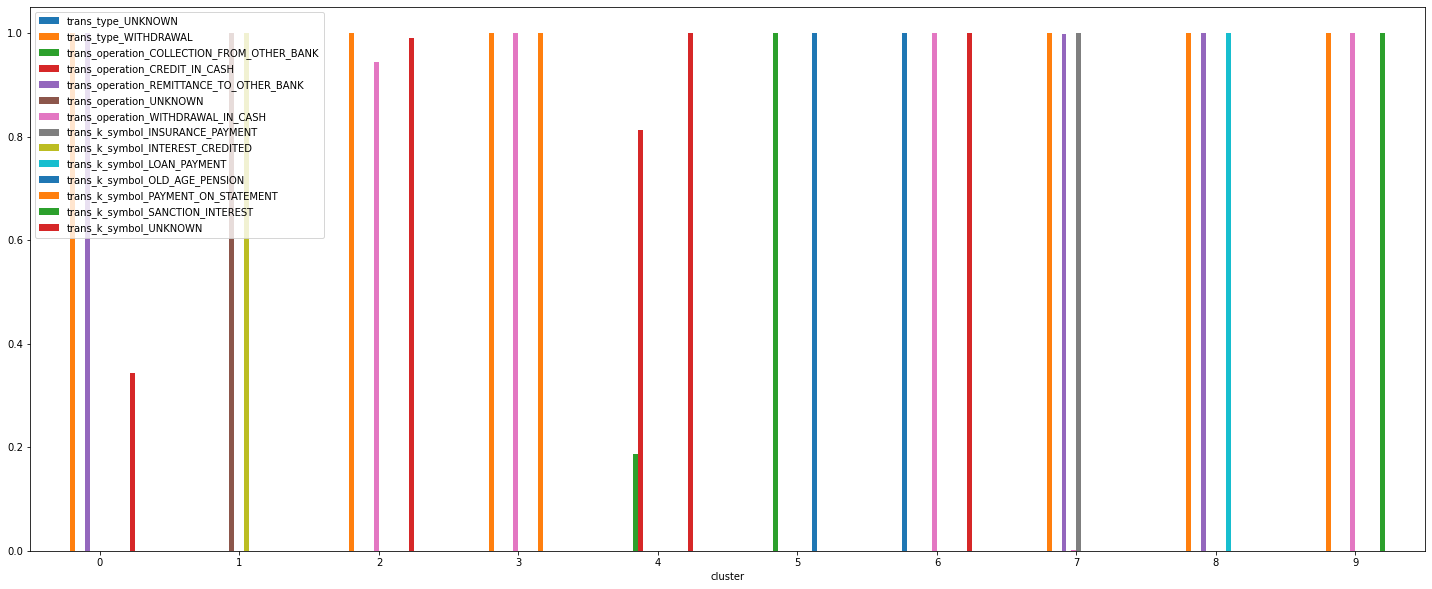

In [307]:
output[['trans_type_UNKNOWN','trans_type_WITHDRAWAL','trans_operation_COLLECTION_FROM_OTHER_BANK','trans_operation_CREDIT_IN_CASH', 'trans_operation_REMITTANCE_TO_OTHER_BANK', 'trans_operation_UNKNOWN', 'trans_operation_WITHDRAWAL_IN_CASH', 'trans_k_symbol_INSURANCE_PAYMENT', 'trans_k_symbol_INTEREST_CREDITED', 'trans_k_symbol_LOAN_PAYMENT', 'trans_k_symbol_OLD_AGE_PENSION', 'trans_k_symbol_PAYMENT_ON_STATEMENT', 'trans_k_symbol_SANCTION_INTEREST', 'trans_k_symbol_UNKNOWN']].plot.bar(rot=0, figsize=(25,10));

In [308]:
df_trans_1998_clus_dummies

,amount,balance,trans_type_UNKNOWN,trans_type_WITHDRAWAL,trans_operation_COLLECTION_FROM_OTHER_BANK,trans_operation_CREDIT_IN_CASH,trans_operation_REMITTANCE_TO_OTHER_BANK,trans_operation_UNKNOWN,trans_operation_WITHDRAWAL_IN_CASH,trans_k_symbol_INSURANCE_PAYMENT,trans_k_symbol_INTEREST_CREDITED,trans_k_symbol_LOAN_PAYMENT,trans_k_symbol_OLD_AGE_PENSION,trans_k_symbol_PAYMENT_ON_STATEMENT,trans_k_symbol_SANCTION_INTEREST,trans_k_symbol_UNKNOWN,cluster
date,,,,,,,,,,,,,,,,,
1998-01-01,1300.0,30951.4,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,2760.0,79264.4,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,3200.0,62735.6,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,390.0,35140.8,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
1998-01-01,8700.0,41905.2,0,1,0,0,0,0,1,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-12-31,62.3,13729.4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1998-12-31,81.3,19544.9,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1998-12-31,60.2,14638.2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [457]:
df_trans_1998_clus_dummies.to_csv("./datasets/df_trans_1998_clus_dummies.csv", index=False)

In [458]:
df_trans_1998_clus_dummies.to_csv("./datasets/df_trans_1998_clus_dummies2.csv", index=True)

In [309]:
df_trans_1998_clus_dummies[df_trans_1998_clus_dummies['cluster'] == 4]

,amount,balance,trans_type_UNKNOWN,trans_type_WITHDRAWAL,trans_operation_COLLECTION_FROM_OTHER_BANK,trans_operation_CREDIT_IN_CASH,trans_operation_REMITTANCE_TO_OTHER_BANK,trans_operation_UNKNOWN,trans_operation_WITHDRAWAL_IN_CASH,trans_k_symbol_INSURANCE_PAYMENT,trans_k_symbol_INTEREST_CREDITED,trans_k_symbol_LOAN_PAYMENT,trans_k_symbol_OLD_AGE_PENSION,trans_k_symbol_PAYMENT_ON_STATEMENT,trans_k_symbol_SANCTION_INTEREST,trans_k_symbol_UNKNOWN,cluster
date,,,,,,,,,,,,,,,,,
1998-01-01,7000.0,71977.9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,33231.0,105867.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,25182.0,61537.9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,11178.0,26157.9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,4800.0,32967.2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-12-30,34595.0,120857.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-12-30,36712.0,92753.3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-12-30,49823.0,142576.3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4


**Client Segmentation - Cluster 4 - Time Series Modelling on Cluster 4 to forecast Transactional Amounts**

In [310]:
df_trans_1998_clus_dummies_clus_x = df_trans_1998_clus_dummies[df_trans_1998_clus_dummies['cluster'] == 4]

In [311]:
df_trans_1998_clus_dummies_clus_x

,amount,balance,trans_type_UNKNOWN,trans_type_WITHDRAWAL,trans_operation_COLLECTION_FROM_OTHER_BANK,trans_operation_CREDIT_IN_CASH,trans_operation_REMITTANCE_TO_OTHER_BANK,trans_operation_UNKNOWN,trans_operation_WITHDRAWAL_IN_CASH,trans_k_symbol_INSURANCE_PAYMENT,trans_k_symbol_INTEREST_CREDITED,trans_k_symbol_LOAN_PAYMENT,trans_k_symbol_OLD_AGE_PENSION,trans_k_symbol_PAYMENT_ON_STATEMENT,trans_k_symbol_SANCTION_INTEREST,trans_k_symbol_UNKNOWN,cluster
date,,,,,,,,,,,,,,,,,
1998-01-01,7000.0,71977.9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,33231.0,105867.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,25182.0,61537.9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,11178.0,26157.9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-01-01,4800.0,32967.2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-12-30,34595.0,120857.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-12-30,36712.0,92753.3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4
1998-12-30,49823.0,142576.3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4


In [455]:
df_trans_1998_clus_dummies_clus_x.to_csv("./datasets/df_trans_1998_clus_dummies_clus_x.csv", index=False)

In [456]:
df_trans_1998_clus_dummies_clus_x.to_csv("./datasets/df_trans_1998_clus_dummies_clus_x2.csv", index=True)

In [312]:
df_trans_1998_clus_x = df_trans_1998_clus_dummies_clus_x[['amount']]

In [313]:
df_trans_1998_clus_x.shape

(55344, 1)

In [314]:
# Code modified from code written by Matthew Garton.

def plot_series(df_trans_1998_clus_x, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df_trans_1998_clus_x[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df_trans_1998_clus_x.index[0::steps], fontsize=18);

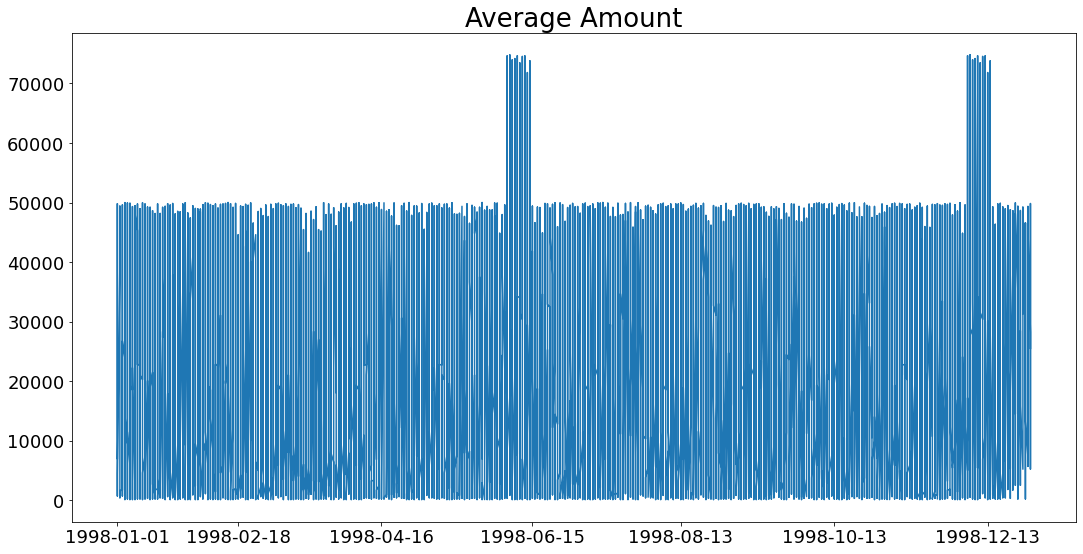

In [326]:
# Generate a time plot of our data.
plot_series(df_trans_1998_clus_x, ['amount'], title = "Average Amount", steps=9000)

In [327]:
df_trans_1998_clus_x.resample('D').mean().shape

(364, 1)

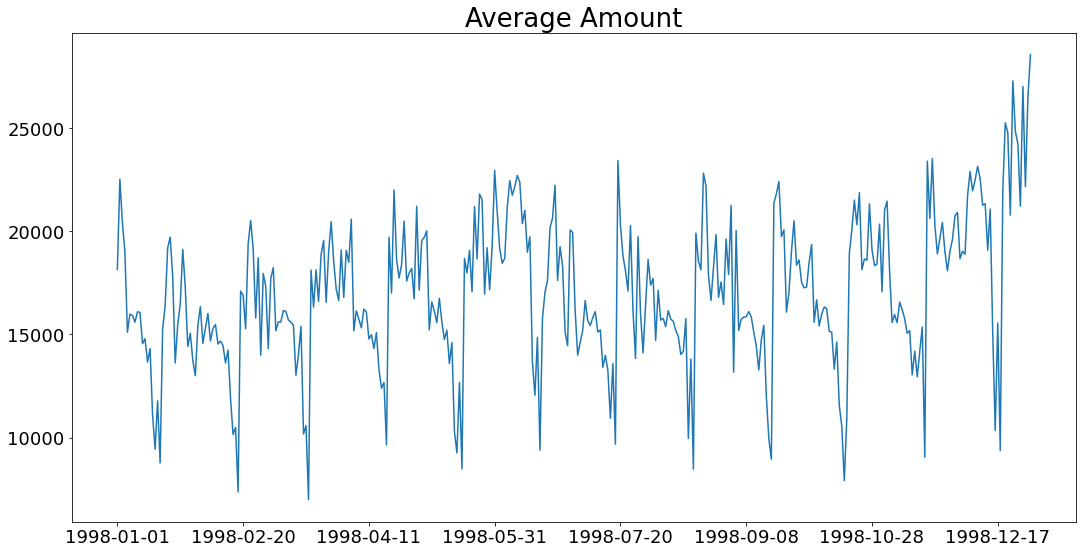

In [333]:
# Generate a time plot of our data.
plot_series(df_trans_1998_clus_x.resample('D').mean(), cols=['amount'], title='Average Amount', steps=50)

In [334]:
# Overwrite df.
df_trans_1998_clus_x = df_trans_1998_clus_x.resample('D').mean()
df_trans_1998_clus_x.head()

,amount
date,
1998-01-01,18161.912281
1998-01-02,22523.509434
1998-01-03,20424.000000
1998-01-04,19007.403846
1998-01-05,15103.455764


In [335]:
df_trans_1998_clus_x.shape

(364, 1)

In [336]:
# What index gives us our 80th percentile of rows?
df_trans_1998_clus_x.shape[0] * (4 / 5)

291.2

In [337]:
# Set training data to be first 80% of rows.
train_clus_x = df_trans_1998_clus_x.iloc[0:291]

In [338]:
# Set test data to be last 20% of rows.
test_clus_x = df_trans_1998_clus_x.iloc[291:]

In [339]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 290.
ar1 = ARIMA(endog = train_clus_x['amount'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 291 and end at 363.
preds = model.predict(start=291, end=363)

# Evaluate predictions.
mean_squared_error(test_clus_x['amount'], preds)

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


25817804.05686041

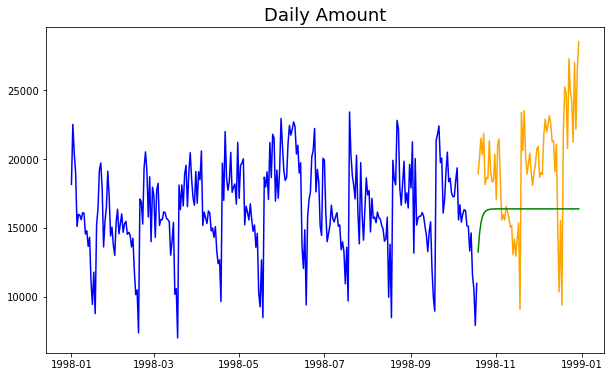

In [340]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train_clus_x['amount'], color = 'blue')

# Plot testing data in orange.
plt.plot(test_clus_x['amount'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Daily Amount', fontsize=18)
plt.show();

In [341]:
# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(train_clus_x['amount']))

Test Statistic   -6.082970e+00
p-value           1.081076e-07
dtype: float64

In [342]:
# Because 𝑝≈1.081076e-07<0.05=𝛼, 
# we reject 𝐻0 that our data are not stationary 
# and accept 𝐻𝐴 that our data are stationary. 
# This means we can fit an ARIMA model to this data without differencing.

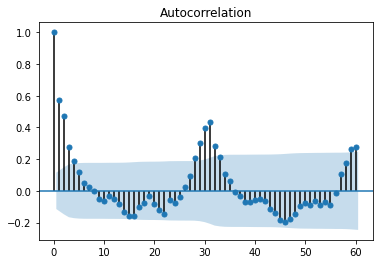

In [343]:
# Generate autocorrelation plot on training data.
plot_acf(train_clus_x['amount'], lags = 60);

# Note: we would generate the ACF plot on 
# differenced data, if we needed to difference
# in order to achieve stationarity!

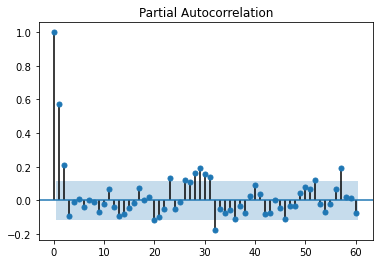

In [344]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train_clus_x['amount'], lags = 60);

# Note: we would generate the PACF plot on 
# differenced data, if we needed to difference
# in order to achieve stationarity!

**Does my PACF have a sharp cut-off?**
> It appears so. I observe a sharp cut-off between lags 0 and 1 as well as a sharp cut-off between lags 1 and 2 in this image. I'll fit two models and compare them (one assuming the cut-off is between 0 and 1, and one assuming the cut-off is between 1 and 2).

**Is the first-lag value in the autocorrelation plot positive or negative?**
> It is positive. (Note that the first-lag value should always be the same in the ACF and PACF plots.)

**What model should we fit?**
> "If your PACF has a sharp cut-off and the first lag of your ACF (autocorrelation function) value is positive, choose an $AR(p)$ term where $p$ is the lag in the PACF after the cut-off." Thus, I will fit an $AR(1)$ model and an $AR(2)$ model and see how well they perform.

In [345]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 290.
ar1 = ARIMA(endog = train_clus_x['amount'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 291 and end at 363.
preds = model.predict(start=291, end=363)

# Evaluate predictions.
mean_squared_error(test_clus_x['amount'], preds)

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


25817804.05686041

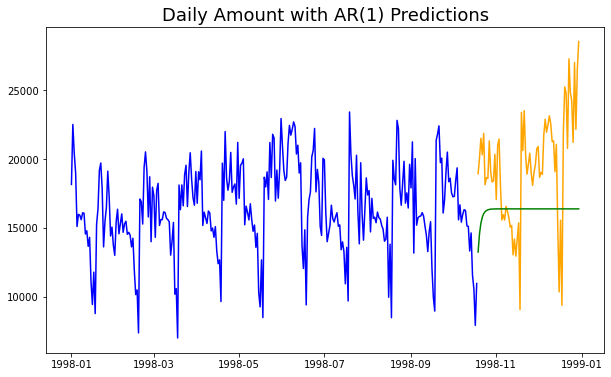

In [346]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train_clus_x['amount'], color = 'blue')
plt.plot(test_clus_x['amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Daily Amount with AR(1) Predictions', fontsize=18)
plt.show();

In [347]:
# Instantiate an AR(2) model on training data.
# Note this training data consists of the 
# time periods 0 through 290.
ar2 = ARIMA(endog = train_clus_x['amount'],
            order = (2, 0, 0)) # (p, d, q)

# Fit AR(2) model.
model = ar2.fit()

# Generate predictions based on test set.
# Start at time period 291 and end at 363.
preds = model.predict(start=291, end=363)

# Evaluate predictions.
mean_squared_error(test_clus_x['amount'], preds)

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


27261086.50950785

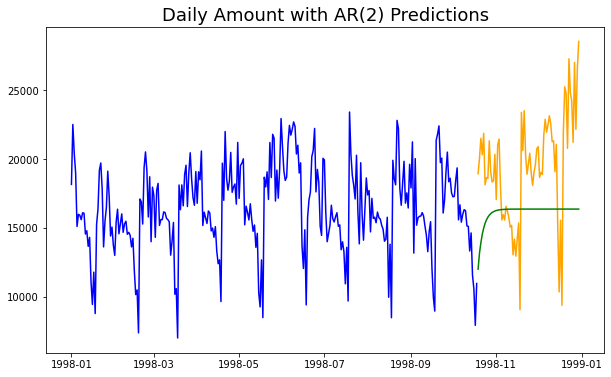

In [348]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train_clus_x['amount'], color = 'blue')
plt.plot(test_clus_x['amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Daily Amount with AR(2) Predictions', fontsize=18)
plt.show();

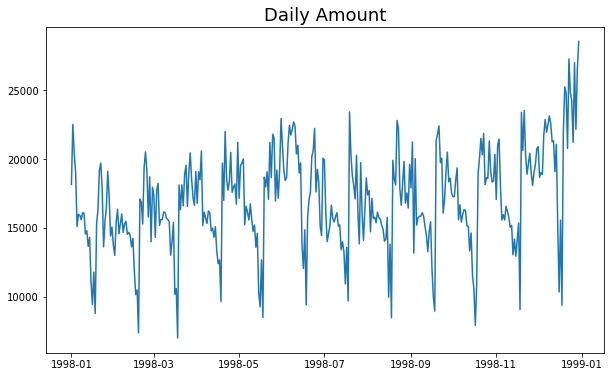

In [349]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(df_trans_1998_clus_x['amount'])
plt.title(label = 'Daily Amount', fontsize=18)
plt.show();

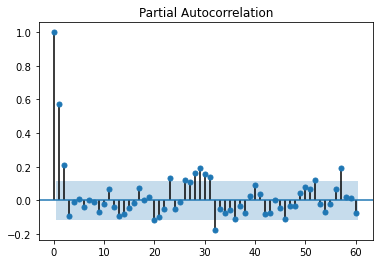

In [350]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train_clus_x['amount'], lags = 60);

C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


13113159.195832508


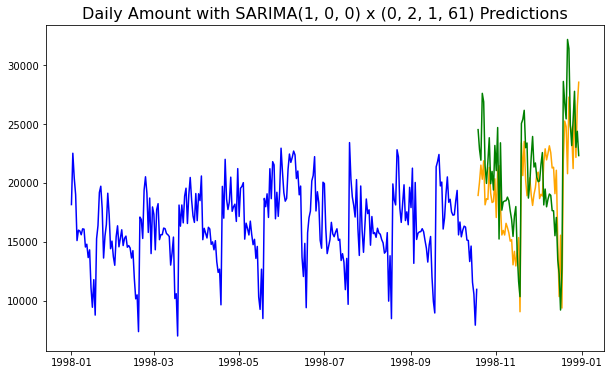

In [454]:
# Fit a SARIMA(1, 0, 0) x (0, 2, 1, 61) model.

sarima = SARIMAX(endog = train_clus_x['amount'],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (0, 2, 1, 61)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 291 and end at 363.
preds = model.predict(start=291, end=363)

# Evaluate predictions.
print(mean_squared_error(test_clus_x['amount'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train_clus_x['amount'], color = 'blue')
plt.plot(test_clus_x['amount'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Daily Amount with SARIMA(1, 0, 0) x (0, 2, 1, 61) Predictions', fontsize=16)
plt.show();

In [449]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = train_clus_x['amount'],
                                 order = (1, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 61)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 291 and end at 363.
                preds = model.predict(start=291, end=363)

                # Evaluate predictions.
                print(f'The MSE for (1, 0, 0)x({P},{D},{Q},61) is: {mean_squared_error(test_clus_x["amount"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(test_clus_x["amount"], preds):
                    mse = mean_squared_error(test_clus_x["amount"], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},61).')
print(f'This model has an MSE of {mse}.')

The MSE for (1, 0, 0)x(0,0,0,61) is: 195029076.60852265
The MSE for (1, 0, 0)x(0,1,0,61) is: 16827087.428645253
The MSE for (1, 0, 0)x(0,2,0,61) is: 33154416.27279424
The MSE for (1, 0, 0)x(0,0,1,61) is: 161627615.48261166


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(0,1,1,61) is: 16458275.183387818


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(0,2,1,61) is: 13113159.195832508


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(0,0,2,61) is: 142074519.2013059


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(0,1,2,61) is: 17516190.859978385


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(0,2,2,61) is: 15214540.822224561


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


The MSE for (1, 0, 0)x(1,0,0,61) is: 141556082.16528714
The MSE for (1, 0, 0)x(1,1,0,61) is: 16562222.127613446
The MSE for (1, 0, 0)x(1,2,0,61) is: 31547141.940861408
The MSE for (1, 0, 0)x(1,0,1,61) is: 128278421.19735412


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(1,1,1,61) is: 20683939.084666636


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 0, 0)x(1,2,1,61) is: 14310420.573695369


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(1,0,2,61) is: 141514941.49248156


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(1,1,2,61) is: 20782345.68710224


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 0, 0)x(1,2,2,61) is: 13177895.857292078
The MSE for (1, 0, 0)x(2,0,0,61) is: 128503485.86531754
The MSE for (1, 0, 0)x(2,1,0,61) is: 17775110.805811662
The MSE for (1, 0, 0)x(2,2,0,61) is: 22340653.502005283
The MSE for (1, 0, 0)x(2,0,1,61) is: 133736190.19048636


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(2,1,1,61) is: 20849875.68153913


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 0, 0)x(2,2,1,61) is: 14243101.184065841


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(2,0,2,61) is: 155790683.79863626


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The MSE for (1, 0, 0)x(2,1,2,61) is: 22722066.102314673


C:\Users\engso\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\engso\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 0, 0)x(2,2,2,61) is: 14247049.70004707
Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,2,1,61).
This model has an MSE of 13113159.195832508.


### The Data Science Process
**5. Evaluation and Conceptual Understanding**<br>
**6. Conclusion and Recommendations**

**Time Series Forecasting on Transactions Amounts**

**Evaluation of Time Series Forecasting**<br>
On Liquidity forecasting, the Seasonal Autoregressive Integrated Moving Average (SARIMA) model with below parameters is able to achieve the lowest mean square error.<br>

Trend Elements<br>
AR(p) Autoregression = 3<br>
I(d) Integration = 0<br>
MA(q) Moving Average = 0<br>

Seasonal Elements<br>
P: Seasonal autoregressive order = 2<br>
D: Seasonal difference order = 0<br>
Q: Seasonal moving average order = 1<br>
S: The number of time steps for a single seasonal period = 52<br>

Minimum mean squared error = 490,000

**Conclusions and Recommendations for Time Series Forecasting**<br>
1. On Liquidity forecasting, SARIMA model with parameters (3,0,0) x (2,0,1,52) on Weekly Transactions Amount data is able to forecast transaction amounts (green) closely with test data (yellow) with minimum mean squared error of 490k
<img src="./datasets/figure1.gif" style="height: 400px">

2. From Transaction Amount forecasting, daily liquidity shortfall reaches (80,000) at its peak and this occurs during the mid-year period from 1993 to 1998.

3. Future scope for enhancement may include including exogenous variables like economic growth, national stock market index or strength of national currency as macroeconomic factors may play a part in the transactions amount fund flows.

**Cluster Segmentation**

**Evaluation of Cluster Segmentation**<br>
Using k = 10 clusters with silhouette score of 0.6227 to cluster the clients from the Transactions Data gives an optimal number of clusters AND also sufficient number of clients per cluster with adequate Transaction Amounts and Balances.
<img src="./datasets/figure2.gif" style="height: 400px">

**Conclusions and Recommendations for Cluster Segmentation**<br>
1. Client Segmentation using K-means clustering – Cluster 4 (1998 Transactions Data)<br>
Cluster 4 having high transaction balance and amount has transaction operation from Collection From Other Bank and Credit In Cash.<br>
Product Recommendations for Cluster 4 may include Investments, Loan and Insurance Product Solutioning.
<img src="./datasets/figure3.gif" style="height: 200px">

<img src="./datasets/figure4.jpg" style="height: 300px">

2. Using time based modelling on Cluster 4 (1998 Transactions Data), we are able to forecast transaction amounts (green) closely with test data (yellow) with mean squared error of 13m<br>
3. With Leads Generation and Recommendations taken to cross-sell Banking Products, we expect Transactions Amount to be higher than below forecast.
<img src="./datasets/figure5.jpg" style="height: 400px">

4. Future scope for enhancement may include client risk rating data so that recommendations for products  may be better tailored for clients' appetite for risk.

**End of current notebook**